# Predict Volatility

## Import Library

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Tracking Modeling
import mlflow
import mlflow.tensorflow

# Garch Modeling
from arch import arch_model

# Modeling Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from itertools import product

# Scalar & Evaluation
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Import Dataset

In [2]:
df = pd.read_pickle('../dataset/feature engineering/clean_data_uji.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              1421 non-null   datetime64[ns]
 1   logreturn_idx     1421 non-null   float64       
 2   logreturn_nyse    1421 non-null   float64       
 3   logreturn_usdidr  1421 non-null   float64       
 4   suku_bunga        1421 non-null   float64       
 5   diffsukubunga     1421 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 66.7 KB


## Garch Modeling

In [3]:
df_vol = (df['logreturn_idx']*100).dropna() #ambil data return idx univariate

garch_11 = arch_model(
    df_vol,
    vol='garch',
    p=1,
    q=1,
    mean='Zero',
    dist='normal'
)

garch_model = garch_11.fit(disp='off') #fit garch modeling

print(garch_model.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:          logreturn_idx   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2198.93
Distribution:                  Normal   AIC:                           4403.85
Method:            Maximum Likelihood   BIC:                           4419.63
                                        No. Observations:                 1421
Date:                Thu, Jan 08 2026   Df Residuals:                     1421
Time:                        14:44:40   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0747  5.387e-02      1.387      0.165 [-3.08

In [4]:
cv = garch_model.conditional_volatility #ambil conditional volatility
cv.name = 'idxcv' #nama kolom

df_vol_return = df[['date','logreturn_idx']] #dataframe return dan conditional volatility
df_vol_return = df_vol_return.join(cv, how='left') #gabungkan conditional volatility dalam data

df_vol = df[['date']] #dataframe hanya date dan conditional volatility
df_vol = df_vol.join(cv, how='left')

In [5]:
df_vol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1421 non-null   datetime64[ns]
 1   idxcv   1421 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 22.3 KB


In [6]:
df_vol.head()

,date,idxcv
0,2020-01-03,1.533409
1,2020-01-06,1.441050
2,2020-01-07,1.382211
3,2020-01-08,1.265933
4,2020-01-09,1.215226


C:\Users\Acer\AppData\Local\Temp\ipykernel_21116\4125961073.py:2: MatplotlibDeprecationWarning: Passing label as a length 1421 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(df_vol['date'], df_vol['idxcv'], label=df_vol['idxcv'])


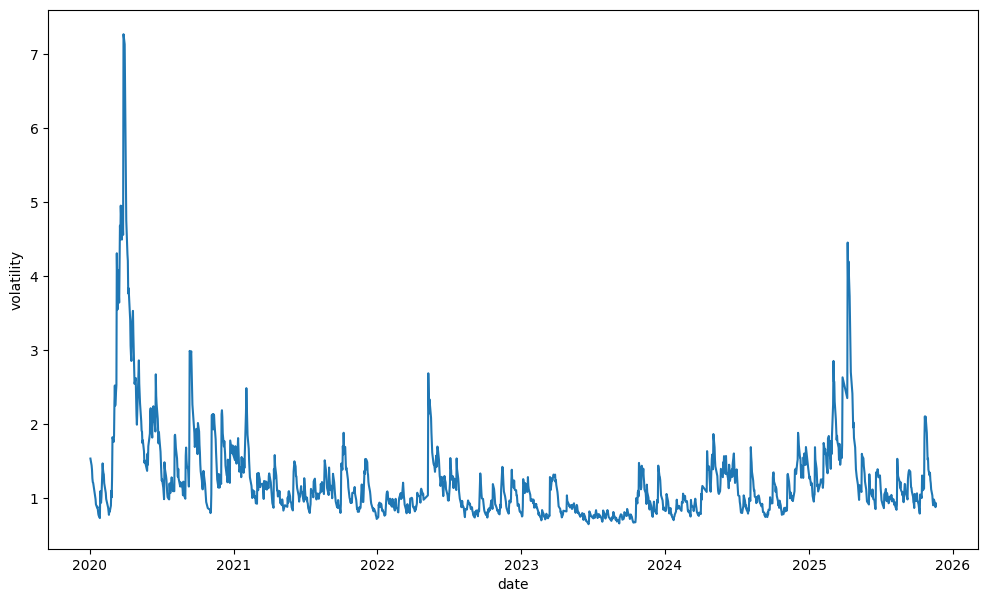

In [7]:
plt.figure(figsize=(12,7))
plt.plot(df_vol['date'], df_vol['idxcv'], label=df_vol['idxcv'])
plt.xlabel('date')
plt.ylabel('volatility')
plt.show()

In [8]:
#Create lags in dataset

# lags = 7

#for i in range(1,lags+1):
    #df_vol[f'idxcv_lag{i}'] = df_vol['idxcv'].shift(i)

#df_vol.head(20)

In [9]:
df_vol[1415:]

,date,idxcv
1415,2025-11-12,0.902667
1416,2025-11-13,0.925502
1417,2025-11-14,0.980541
1418,2025-11-17,0.927332
1419,2025-11-18,0.877424
1420,2025-11-19,0.926740


In [10]:
df_vol.to_pickle('../dataset/modeling/df_vol_nolags.pkl') #save data volatility and lags

In [11]:
df_vol['idxcv'].describe()

count    1421.000000
mean        1.232374
std         0.643084
min         0.646832
25%         0.878756
50%         1.059494
75%         1.342671
max         7.264214
Name: idxcv, dtype: float64

In [12]:
conditional_varianse = df_vol['idxcv']**2

conditional_varianse.describe()

count    1421.000000
mean        1.932012
std         3.462444
min         0.418392
25%         0.772213
50%         1.122528
75%         1.802766
max        52.768810
Name: idxcv, dtype: float64

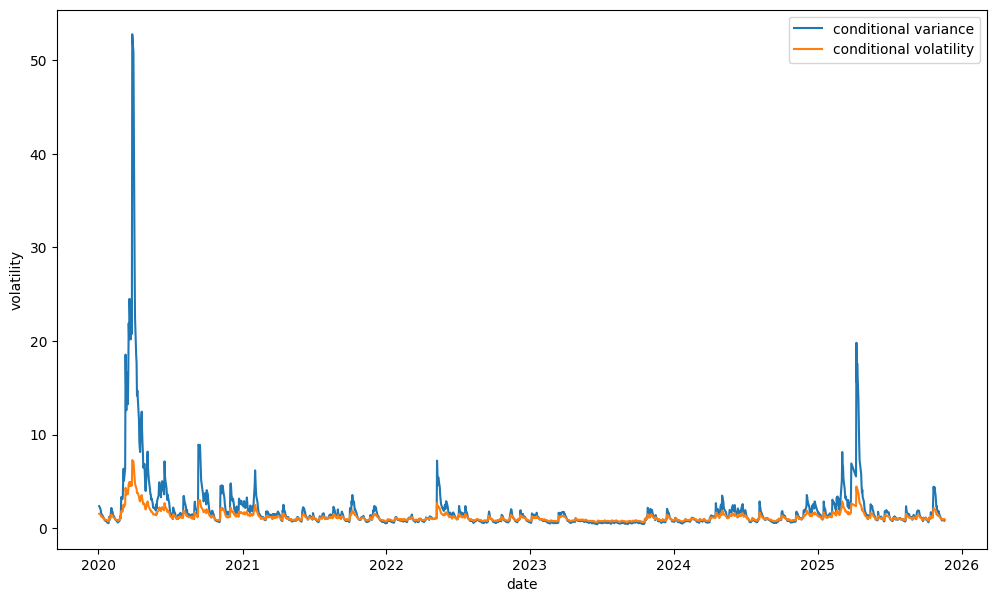

In [13]:
plt.figure(figsize=(12,7))
plt.plot(df_vol['date'], df_vol['idxcv'] **2, label='conditional variance')
plt.plot(df_vol['date'], df_vol['idxcv'], label='conditional volatility')
plt.xlabel('date')
plt.legend()
plt.ylabel('volatility')
plt.show()

In [14]:
df_vol['log_cv'] = np.log(df_vol['idxcv'])
df_vol.head()

,date,idxcv,log_cv
0,2020-01-03,1.533409,0.427494
1,2020-01-06,1.441050,0.365372
2,2020-01-07,1.382211,0.323684
3,2020-01-08,1.265933,0.235809
4,2020-01-09,1.215226,0.194930


In [15]:
df_vol.describe()

,date,idxcv,log_cv
count,1421,1421.000000,1421.000000
mean,2022-12-06 06:04:48.810696448,1.232374,0.129518
min,2020-01-03 00:00:00,0.646832,-0.435669
25%,2021-06-23 00:00:00,0.878756,-0.129248
50%,2022-11-29 00:00:00,1.059494,0.057792
75%,2024-05-30 00:00:00,1.342671,0.294661
max,2025-11-19 00:00:00,7.264214,1.982960
std,NaN,0.643084,0.360515


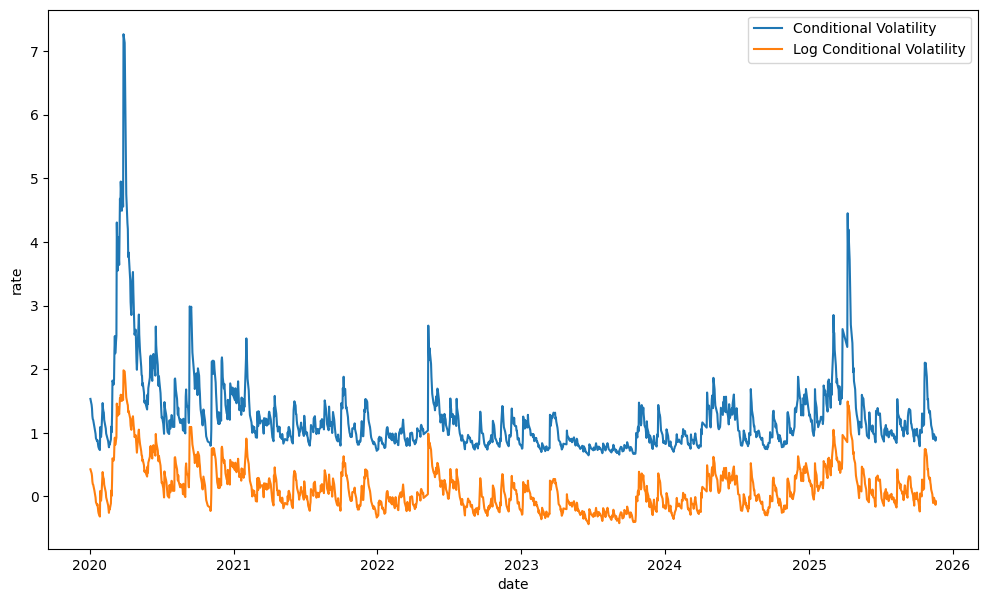

In [16]:
plt.figure(figsize=(12,7))
plt.plot(df_vol['date'], df_vol['idxcv'], label='Conditional Volatility')
plt.plot(df_vol['date'], df_vol['log_cv'], label='Log Conditional Volatility')
plt.legend()
plt.xlabel('date')
plt.ylabel('rate')
plt.show()

## LSTM Modeling

In [17]:
df_vol.describe()

,date,idxcv,log_cv
count,1421,1421.000000,1421.000000
mean,2022-12-06 06:04:48.810696448,1.232374,0.129518
min,2020-01-03 00:00:00,0.646832,-0.435669
25%,2021-06-23 00:00:00,0.878756,-0.129248
50%,2022-11-29 00:00:00,1.059494,0.057792
75%,2024-05-30 00:00:00,1.342671,0.294661
max,2025-11-19 00:00:00,7.264214,1.982960
std,NaN,0.643084,0.360515


In [18]:
df_vol = df_vol.set_index('date') #jadikan kolom date sebagai indeks
df_vol.head()

,idxcv,log_cv
date,,
2020-01-03,1.533409,0.427494
2020-01-06,1.441050,0.365372
2020-01-07,1.382211,0.323684
2020-01-08,1.265933,0.235809
2020-01-09,1.215226,0.194930


In [19]:
#Splitting Data

df_vol = df_vol['idxcv'] #ambil nilai conditional volatility
df_vol = df_vol.values #konversi ke numpy array

n = len(df_vol) #panjang data

train_ratio = 0.8 #80% data untuk train
val_ratio = 0.1 #10% untuk val

panjang_train = int(n*train_ratio) #ambil 80% dari jumlah data sebagai data train
panjang_val = int(n*(train_ratio + val_ratio)) #ambil 90% data dari jumlah data

df_train = df_vol[:panjang_train] #ambil 80% data awal dalam dataset sebagai train
df_val = df_vol[panjang_train:panjang_val] #ambil data dengan rentang 80-90% dari dataset sebagai val
df_test = df_vol[panjang_val:] #ambil data dari 90-100% sebagai test

print(len(df_train), len(df_val), len(df_test))

1136 142 143


In [20]:
# Terapkan Scalar pada dataset

scaler = StandardScaler() #panggil fungsi skalar
scaler.fit(df_train.reshape(-1,1)) #fit kan skalar pada data train

train_scaled = scaler.transform(df_train.reshape(-1,1)) #transform data train
val_scaled = scaler.transform(df_val.reshape(-1,1)) #transform data val
test_scaled = scaler.transform(df_test.reshape(-1,1)) #transform data test

In [21]:
print("data train: ",len(train_scaled))
print("data val: ",len(val_scaled))
print("data test: ",len(test_scaled))

data train:  1136
data val:  142
data test:  143


In [22]:
#create sequence
def create_sequence(data, window, horizon):
    X, y = [], []
    for i in range(len(data)-window-horizon + 1):
        X.append(data[i:i+window])
        y.append(data[i+window : i+window+horizon])
    return np.array(X), np.array(y)

### Mencari window size terbaik

#### Horizon 5

In [57]:
mlflow.set_experiment('LSTM_Window_Tuning_hor5')

window = [5, 10, 15] #estimasi window yang akan digunakan
horizon = 5 #prediksi pada waktu-t
results = [] #menyimpan hasil pemodelan pada beberapa estimasi window

for i in window:
    
    with mlflow.start_run(run_name=f"window_{i}"):
        
        #Sequence data train, val dan test
        X_train, y_train = create_sequence(train_scaled, i, horizon)
        X_val, y_val = create_sequence(val_scaled, i, horizon)
        X_test, y_test = create_sequence(test_scaled, i, horizon)
        print(X_train.shape, X_val.shape, X_test.shape)
        print(y_train.shape, y_val.shape, y_test.shape)


        #log Params
        mlflow.log_param('window_size', i)
        mlflow.log_param('model_type', 'lstm')
        mlflow.log_param('horizon', horizon)
        mlflow.log_param('LSTM_units', 32)
        mlflow.log_param('optimizer', 'adam')
        mlflow.log_param('loss', 'mse')
        mlflow.log_param('epochs', 50)
        
    
    
        #Buat baseline Model untuk menguji beberapa window
        model = Sequential([
            LSTM(32, input_shape=(i, 1)),
            Dense(horizon)
        ])
        model.compile(optimizer='adam', loss = 'mse')
        print(model.summary())


        
        #train model baseline
        history = model.fit(
            X_train, y_train,
            validation_data = (X_val, y_val),
            epochs = 50,
            verbose=0
        )


        #log metric per epoch
        for epoch in range(len(history.history["loss"])):
            mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
            mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
    


        
        #Final evaluation
        train_mse = model.evaluate(X_train, y_train, verbose=0)
        val_mse   = model.evaluate(X_val, y_val, verbose=0)
        mlflow.log_metric("final_train_mse", train_mse)
        mlflow.log_metric("final_val_mse", val_mse)

        
        
        #visualisasi train loss dan validation loss
        plot_path = f"loss_curve_window_{i}.png"
        plt.figure(figsize=(8,4))
        plt.plot(history.history["loss"], label="Train")
        plt.plot(history.history["val_loss"], label="Val")
        plt.legend()
        plt.grid(True)
        plt.title(f"Loss Curve (window={i})")
        plt.savefig(plot_path)
        plt.close()
        mlflow.log_artifact(plot_path)
    

        
        #simpan hasil percobaan dalam results
        results.append({
            'window': i,
            'train_mse': train_mse,
            'val_mse': val_mse
        })

(1127, 5, 1) (133, 5, 1) (134, 5, 1)
(1127, 5, 1) (133, 5, 1) (134, 5, 1)


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_126 (LSTM)                      │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_101 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,517 (17.64 KB)

 Trainable params: 4,517 (17.64 KB)

 Non-trainable params: 0 (0.00 B)

None
(1122, 10, 1) (128, 10, 1) (129, 10, 1)
(1122, 5, 1) (128, 5, 1) (129, 5, 1)


Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_127 (LSTM)                      │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_102 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,517 (17.64 KB)

 Trainable params: 4,517 (17.64 KB)

 Non-trainable params: 0 (0.00 B)

None
(1117, 15, 1) (123, 15, 1) (124, 15, 1)
(1117, 5, 1) (123, 5, 1) (124, 5, 1)


Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_128 (LSTM)                      │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_103 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,517 (17.64 KB)

 Trainable params: 4,517 (17.64 KB)

 Non-trainable params: 0 (0.00 B)

None


In [58]:
results = pd.DataFrame(results)
results['gap'] = (results['train_mse'] - results['val_mse']).abs()
results.sort_values(by='gap',ascending=True)

,window,train_mse,val_mse,gap
0,5,0.200728,0.441638,0.240911
1,10,0.161921,0.456295,0.294374
2,15,0.145094,0.474084,0.328990


#### Horizon 20

In [44]:
mlflow.set_experiment('LSTM_Window_Tuning_hor20')

window = [20, 30, 40, 60, 80, 100, 120] #estimasi window yang akan digunakan
horizon = 20 #prediksi pada waktu-t
results = [] #menyimpan hasil pemodelan pada beberapa estimasi window

for i in window:
    
    with mlflow.start_run(run_name=f"window_{i}"):
        
        #Sequence data train, val dan test
        X_train, y_train = create_sequence(train_scaled, i, horizon)
        X_val, y_val = create_sequence(val_scaled, i, horizon)
        X_test, y_test = create_sequence(test_scaled, i, horizon)
        print(X_train.shape, X_val.shape, X_test.shape)
        print(y_train.shape, y_val.shape, y_test.shape)


        #log Params
        mlflow.log_param('window_size', i)
        mlflow.log_param('model_type', 'lstm')
        mlflow.log_param('horizon', horizon)
        mlflow.log_param('LSTM_units', 32)
        mlflow.log_param('optimizer', 'adam')
        mlflow.log_param('loss', 'mse')
        mlflow.log_param('epochs', 50)
        
    
    
        #Buat baseline Model untuk menguji beberapa window
        model = Sequential([
            LSTM(32, input_shape=(i, 1)),
            Dense(horizon)
        ])
        model.compile(optimizer='adam', loss = 'mse')
        print(model.summary())


        
        #train model baseline
        history = model.fit(
            X_train, y_train,
            validation_data = (X_val, y_val),
            epochs = 50,
            verbose=0
        )


        #log metric per epoch
        for epoch in range(len(history.history["loss"])):
            mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
            mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
    


        
        #Final evaluation
        train_mse = model.evaluate(X_train, y_train, verbose=0)
        val_mse   = model.evaluate(X_val, y_val, verbose=0)
        mlflow.log_metric("final_train_mse", train_mse)
        mlflow.log_metric("final_val_mse", val_mse)

        
        
        #visualisasi train loss dan validation loss
        plot_path = f"loss_curve_window_{i}.png"
        plt.figure(figsize=(8,4))
        plt.plot(history.history["loss"], label="Train")
        plt.plot(history.history["val_loss"], label="Val")
        plt.legend()
        plt.grid(True)
        plt.title(f"Loss Curve (window={i})")
        plt.savefig(plot_path)
        plt.close()
        mlflow.log_artifact(plot_path)
    

        
        #simpan hasil percobaan dalam results
        results.append({
            'window': i,
            'train_mse': train_mse,
            'val_mse': val_mse
        })

2026/01/02 16:17:15 INFO mlflow.tracking.fluent: Experiment with name 'LSTM_Window_Tuning_hor20' does not exist. Creating a new experiment.


(1097, 20, 1) (103, 20, 1) (104, 20, 1)
(1097, 20, 1) (103, 20, 1) (104, 20, 1)


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_49 (LSTM)                       │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,012 (19.58 KB)

 Trainable params: 5,012 (19.58 KB)

 Non-trainable params: 0 (0.00 B)

None
(1087, 30, 1) (93, 30, 1) (94, 30, 1)
(1087, 20, 1) (93, 20, 1) (94, 20, 1)


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_50 (LSTM)                       │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,012 (19.58 KB)

 Trainable params: 5,012 (19.58 KB)

 Non-trainable params: 0 (0.00 B)

None
(1077, 40, 1) (83, 40, 1) (84, 40, 1)
(1077, 20, 1) (83, 20, 1) (84, 20, 1)


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_51 (LSTM)                       │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,012 (19.58 KB)

 Trainable params: 5,012 (19.58 KB)

 Non-trainable params: 0 (0.00 B)

None
(1057, 60, 1) (63, 60, 1) (64, 60, 1)
(1057, 20, 1) (63, 20, 1) (64, 20, 1)


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_52 (LSTM)                       │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,012 (19.58 KB)

 Trainable params: 5,012 (19.58 KB)

 Non-trainable params: 0 (0.00 B)

None
(1037, 80, 1) (43, 80, 1) (44, 80, 1)
(1037, 20, 1) (43, 20, 1) (44, 20, 1)


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_53 (LSTM)                       │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,012 (19.58 KB)

 Trainable params: 5,012 (19.58 KB)

 Non-trainable params: 0 (0.00 B)

None
(1017, 100, 1) (23, 100, 1) (24, 100, 1)
(1017, 20, 1) (23, 20, 1) (24, 20, 1)


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_54 (LSTM)                       │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,012 (19.58 KB)

 Trainable params: 5,012 (19.58 KB)

 Non-trainable params: 0 (0.00 B)

None
(997, 120, 1) (3, 120, 1) (4, 120, 1)
(997, 20, 1) (3, 20, 1) (4, 20, 1)


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_55 (LSTM)                       │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,012 (19.58 KB)

 Trainable params: 5,012 (19.58 KB)

 Non-trainable params: 0 (0.00 B)

None


In [45]:
results = pd.DataFrame(results)
results['gap'] = (results['train_mse'] - results['val_mse']).abs()
results.sort_values(by='gap',ascending=True)

,window,train_mse,val_mse,gap
0,20,0.354401,0.622593,0.268192
1,30,0.313803,0.670114,0.356311
2,40,0.260659,0.676358,0.415699
3,60,0.136259,0.918070,0.781811
4,80,0.162535,1.091581,0.929046
5,100,0.134591,2.188130,2.053539
6,120,0.124661,4.878054,4.753393


### Mencari Window Terbaik - Earlystop

#### Horizon 5

In [59]:
mlflow.set_experiment('LSTM_Window_Tuning_Earlystop_hor5')

window = [5,10,15] #estimasi window yang akan digunakan
horizon = 5 #prediksi pada waktu-t
results = [] #menyimpan hasil pemodelan pada beberapa estimasi window

for i in window:
    
    with mlflow.start_run(run_name=f"window_{i}"):

        #Sequence data train, val dan test
        X_train, y_train = create_sequence(train_scaled, i, horizon)
        X_val, y_val = create_sequence(val_scaled, i, horizon)
        X_test, y_test = create_sequence(test_scaled, i, horizon)
        print(X_train.shape, X_val.shape, X_test.shape)
        print(y_train.shape, y_val.shape, y_test.shape)


        
        #log Params
        mlflow.log_param('window_size', i)
        mlflow.log_param('model_type', 'lstm')
        mlflow.log_param('horizon', horizon)
        mlflow.log_param('LSTM_units', 32)
        mlflow.log_param('optimizer', 'adam')
        mlflow.log_param('loss', 'mse')
        mlflow.log_param('epochs', 50)

        
    
    
        #Buat baseline Model untuk menguji beberapa window
        model = Sequential([
            LSTM(32, input_shape=(i, 1)),
            Dense(horizon)
        ])
        model.compile(optimizer='adam', loss = 'mse')
        print(model.summary())


        

        #earlystop
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
        
        #train model baseline
        history = model.fit(
            X_train, y_train,
            validation_data = (X_val, y_val),
            epochs = 50,
            verbose=0,
            callbacks=[early_stop]
        )



    
        #log metric per epoch
        for epoch in range(len(history.history["loss"])):
            mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
            mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
    


        
        #Final evaluation
        train_mse = model.evaluate(X_train, y_train, verbose=0)
        val_mse   = model.evaluate(X_val, y_val, verbose=0)
        mlflow.log_metric("final_train_mse", train_mse)
        mlflow.log_metric("final_val_mse", val_mse)

        
        
        #visualisasi train loss dan validation loss
        plot_path = f"loss_curve_window_{i}.png"
        plt.figure(figsize=(8,4))
        plt.plot(history.history["loss"], label="Train")
        plt.plot(history.history["val_loss"], label="Val")
        plt.legend()
        plt.grid(True)
        plt.title(f"Loss Curve (window={i})")
        plt.savefig(plot_path)
        plt.close()
        mlflow.log_artifact(plot_path)
    

        
        #simpan hasil percobaan dalam results
        results.append({
            'window': i,
            'train_mse': train_mse,
            'val_mse': val_mse
        })

(1127, 5, 1) (133, 5, 1) (134, 5, 1)
(1127, 5, 1) (133, 5, 1) (134, 5, 1)


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_129 (LSTM)                      │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_104 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,517 (17.64 KB)

 Trainable params: 4,517 (17.64 KB)

 Non-trainable params: 0 (0.00 B)

None
(1122, 10, 1) (128, 10, 1) (129, 10, 1)
(1122, 5, 1) (128, 5, 1) (129, 5, 1)


Model: "sequential_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_130 (LSTM)                      │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_105 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,517 (17.64 KB)

 Trainable params: 4,517 (17.64 KB)

 Non-trainable params: 0 (0.00 B)

None
(1117, 15, 1) (123, 15, 1) (124, 15, 1)
(1117, 5, 1) (123, 5, 1) (124, 5, 1)


Model: "sequential_106"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_131 (LSTM)                      │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_106 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,517 (17.64 KB)

 Trainable params: 4,517 (17.64 KB)

 Non-trainable params: 0 (0.00 B)

None


In [60]:
results = pd.DataFrame(results)
results['gap'] = (results['train_mse'] - results['val_mse']).abs()
results.sort_values(by='gap',ascending=True)

,window,train_mse,val_mse,gap
0,5,0.201220,0.447030,0.245810
1,10,0.198461,0.449021,0.250560
2,15,0.220057,0.481265,0.261207


#### Horizon 20

In [48]:
mlflow.set_experiment('LSTM_Window_Tuning_Earlystop_hor20')

window = [20, 30, 40, 60, 80, 100, 120] #estimasi window yang akan digunakan
horizon = 20 #prediksi pada waktu-t
results = [] #menyimpan hasil pemodelan pada beberapa estimasi window

for i in window:
    
    with mlflow.start_run(run_name=f"window_{i}"):

        #Sequence data train, val dan test
        X_train, y_train = create_sequence(train_scaled, i, horizon)
        X_val, y_val = create_sequence(val_scaled, i, horizon)
        X_test, y_test = create_sequence(test_scaled, i, horizon)
        print(X_train.shape, X_val.shape, X_test.shape)
        print(y_train.shape, y_val.shape, y_test.shape)


        
        #log Params
        mlflow.log_param('window_size', i)
        mlflow.log_param('model_type', 'lstm')
        mlflow.log_param('horizon', horizon)
        mlflow.log_param('LSTM_units', 32)
        mlflow.log_param('optimizer', 'adam')
        mlflow.log_param('loss', 'mse')
        mlflow.log_param('epochs', 50)

        
    
    
        #Buat baseline Model untuk menguji beberapa window
        model = Sequential([
            LSTM(32, input_shape=(i, 1)),
            Dense(horizon)
        ])
        model.compile(optimizer='adam', loss = 'mse')
        print(model.summary())


        

        #earlystop
        early_stop = EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
        
        #train model baseline
        history = model.fit(
            X_train, y_train,
            validation_data = (X_val, y_val),
            epochs = 50,
            verbose=0,
            callbacks=[early_stop]
        )



    
        #log metric per epoch
        for epoch in range(len(history.history["loss"])):
            mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
            mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
    


        
        #Final evaluation
        train_mse = model.evaluate(X_train, y_train, verbose=0)
        val_mse   = model.evaluate(X_val, y_val, verbose=0)
        mlflow.log_metric("final_train_mse", train_mse)
        mlflow.log_metric("final_val_mse", val_mse)

        
        
        #visualisasi train loss dan validation loss
        plot_path = f"loss_curve_window_{i}.png"
        plt.figure(figsize=(8,4))
        plt.plot(history.history["loss"], label="Train")
        plt.plot(history.history["val_loss"], label="Val")
        plt.legend()
        plt.grid(True)
        plt.title(f"Loss Curve (window={i})")
        plt.savefig(plot_path)
        plt.close()
        mlflow.log_artifact(plot_path)
    

        
        #simpan hasil percobaan dalam results
        results.append({
            'window': i,
            'train_mse': train_mse,
            'val_mse': val_mse
        })

2026/01/02 16:26:26 INFO mlflow.tracking.fluent: Experiment with name 'LSTM_Window_Tuning_Earlystop_hor20' does not exist. Creating a new experiment.


(1097, 20, 1) (103, 20, 1) (104, 20, 1)
(1097, 20, 1) (103, 20, 1) (104, 20, 1)


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_63 (LSTM)                       │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,012 (19.58 KB)

 Trainable params: 5,012 (19.58 KB)

 Non-trainable params: 0 (0.00 B)

None
(1087, 30, 1) (93, 30, 1) (94, 30, 1)
(1087, 20, 1) (93, 20, 1) (94, 20, 1)


Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_64 (LSTM)                       │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,012 (19.58 KB)

 Trainable params: 5,012 (19.58 KB)

 Non-trainable params: 0 (0.00 B)

None
(1077, 40, 1) (83, 40, 1) (84, 40, 1)
(1077, 20, 1) (83, 20, 1) (84, 20, 1)


Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_65 (LSTM)                       │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,012 (19.58 KB)

 Trainable params: 5,012 (19.58 KB)

 Non-trainable params: 0 (0.00 B)

None
(1057, 60, 1) (63, 60, 1) (64, 60, 1)
(1057, 20, 1) (63, 20, 1) (64, 20, 1)


Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_66 (LSTM)                       │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,012 (19.58 KB)

 Trainable params: 5,012 (19.58 KB)

 Non-trainable params: 0 (0.00 B)

None
(1037, 80, 1) (43, 80, 1) (44, 80, 1)
(1037, 20, 1) (43, 20, 1) (44, 20, 1)


Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_67 (LSTM)                       │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,012 (19.58 KB)

 Trainable params: 5,012 (19.58 KB)

 Non-trainable params: 0 (0.00 B)

None
(1017, 100, 1) (23, 100, 1) (24, 100, 1)
(1017, 20, 1) (23, 20, 1) (24, 20, 1)


Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_68 (LSTM)                       │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,012 (19.58 KB)

 Trainable params: 5,012 (19.58 KB)

 Non-trainable params: 0 (0.00 B)

None
(997, 120, 1) (3, 120, 1) (4, 120, 1)
(997, 20, 1) (3, 20, 1) (4, 20, 1)


Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_69 (LSTM)                       │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,012 (19.58 KB)

 Trainable params: 5,012 (19.58 KB)

 Non-trainable params: 0 (0.00 B)

None


In [49]:
results = pd.DataFrame(results)
results['gap'] = (results['train_mse'] - results['val_mse']).abs()
results.sort_values(by='gap',ascending=True)

,window,train_mse,val_mse,gap
2,40,0.517862,0.563989,0.046127
0,20,0.546456,0.466788,0.079668
1,30,0.601415,0.484204,0.117211
3,60,0.204759,0.870850,0.666091
4,80,0.195562,1.167184,0.971623
5,100,0.193137,1.829559,1.636422
6,120,0.184921,4.242184,4.057264


### Menentukan Arsitektur Terbaik

#### Horizon 5

##### Tanpa Earlystop

In [ ]:
# mlflow.set_experiment('LSTM_Architecture_Tuning_h5')

# window = 5 #window terbaik
# horizon = 5 #prediksi pada waktu-t
# use_layers = [1,2] #jumlah layer yang digunakan
# unit_layers = [8,16,32,64,128] #jumlah unit yang diguanakn
# results = [] #menyimpan hasil pemodelan pada beberapa estimasi window


# #Sequence data train, val dan test
# X_train, y_train = create_sequence(train_scaled, window, horizon)
# X_val, y_val = create_sequence(val_scaled, window, horizon)
# X_test, y_test = create_sequence(test_scaled, window, horizon)
# print(X_train.shape, X_val.shape, X_test.shape)
# print(y_train.shape, y_val.shape, y_test.shape)



# for i in use_layers:
    
#     units_kombinasi = list(product(unit_layers, repeat=i)) # semua kombinasi unit untuk n_layers
    
#     for j in units_kombinasi:

#         run_name = f"L{i}_U{'-'.join(map(str, j))}"
        
#         with mlflow.start_run(run_name=run_name):
        
#             model = Sequential() #buat model sequential
    
#             for indeks_layer, unit in enumerate(j):
                
#                 return_seq = indeks_layer < i -1 #jika layer buakn layer terakhir, maka return_seq True
    
#                 if indeks_layer == 0: #jika indeks layer 0, maka ini merupakan layer pertama
#                     model.add(
#                         LSTM(unit, return_sequences=return_seq, input_shape=(window,1))
#                     )
#                 else: #jika indeks selain dari 0, maka ini merupakan layer ke 2, 3 dan seterusnya
#                     model.add(
#                         LSTM(unit, return_sequences=return_seq)
#                     )
                    
#             model.add(Dense(horizon))
            
#             model.compile(
#                 optimizer='adam',
#                 loss = 'mse'
#             )
            
#             print(model.summary())
    
            
            
            
#             #log Params
#             mlflow.log_param("window_size", window)
#             mlflow.log_param("horizon", horizon)
#             mlflow.log_param("num_layers", i)
#             mlflow.log_param("units_per_layer", j)
#             mlflow.log_param("optimizer", "adam")
#             mlflow.log_param("loss", "mse")
#             mlflow.log_param("epochs", 50)
        
            
            
            
            
            
#             #Train Model
#             history = model.fit(
#                 X_train, y_train,
#                 validation_data = (X_val, y_val),
#                 epochs = 50,
#                 verbose= 0
#             )
    
    
    
            
#             #log metric per epoch
#             for epoch in range(len(history.history["loss"])):
#                 mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
#                 mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
    
    
                
    
    
    
#             # evaluasi kuantitatif mse
#             train_mse = model.evaluate(X_train, y_train, verbose=0)
#             val_mse   = model.evaluate(X_val, y_val, verbose=0)
#             mlflow.log_metric("final_train_mse", train_mse)
#             mlflow.log_metric("final_val_mse", val_mse)
            
            
            
            
            
#             #visualisasi train loss dan validation loss
#             plot_path = f"loss_{run_name}.png"
#             plt.figure(figsize=(8,4))
#             plt.plot(history.history["loss"], label="Train")
#             plt.plot(history.history["val_loss"], label="Val")
#             plt.legend()
#             plt.grid(True)
#             plt.title(run_name)
#             plt.savefig(plot_path)
#             plt.close()
#             mlflow.log_artifact(plot_path)
        
            
            
            
            
#             #simpan hasil percobaan dalam results
#             results.append({
#                 'layer': i,
#                 'units' : j,
#                 'train_mse': train_mse,
#                 'val_mse': val_mse
#             })

##### one layer - tanpa earlystop

In [23]:
mlflow.set_experiment('LSTM_Architecture_Tuning_h5')

window = 5 #window terbaik
horizon = 5 #prediksi pada waktu-t
use_layers = [1] #jumlah layer yang digunakan
unit_layers = [1,2,3,4,5,6,7,8,16] #jumlah unit yang diguanakn
results = [] #menyimpan hasil pemodelan pada beberapa estimasi window


#Sequence data train, val dan test
X_train, y_train = create_sequence(train_scaled, window, horizon)
X_val, y_val = create_sequence(val_scaled, window, horizon)
X_test, y_test = create_sequence(test_scaled, window, horizon)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)



for i in use_layers:
    
    units_kombinasi = list(product(unit_layers, repeat=i)) # semua kombinasi unit untuk n_layers
    
    for j in units_kombinasi:

        run_name = f"L{i}_U{'-'.join(map(str, j))}"
        
        with mlflow.start_run(run_name=run_name):
        
            model = Sequential() #buat model sequential
    
            for indeks_layer, unit in enumerate(j):
                
                return_seq = indeks_layer < i -1 #jika layer buakn layer terakhir, maka return_seq True
    
                if indeks_layer == 0: #jika indeks layer 0, maka ini merupakan layer pertama
                    model.add(
                        LSTM(unit, return_sequences=return_seq, input_shape=(window,1))
                    )
                else: #jika indeks selain dari 0, maka ini merupakan layer ke 2, 3 dan seterusnya
                    model.add(
                        LSTM(unit, return_sequences=return_seq)
                    )
                    
            model.add(Dense(horizon))
            
            model.compile(
                optimizer='adam',
                loss = 'mse'
            )
            
            print(model.summary())
    
            
            
            
            #log Params
            mlflow.log_param("window_size", window)
            mlflow.log_param("horizon", horizon)
            mlflow.log_param("num_layers", i)
            mlflow.log_param("units_per_layer", j)
            mlflow.log_param("optimizer", "adam")
            mlflow.log_param("loss", "mse")
            mlflow.log_param("epochs", 50)
        
            
            
            
            
            
            #Train Model
            history = model.fit(
                X_train, y_train,
                validation_data = (X_val, y_val),
                epochs = 50,
                verbose= 0
            )
    
    
    
            
            #log metric per epoch
            for epoch in range(len(history.history["loss"])):
                mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
                mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
    
    
                
    
    
    
            # evaluasi kuantitatif mse
            train_mse = model.evaluate(X_train, y_train, verbose=0)
            val_mse   = model.evaluate(X_val, y_val, verbose=0)
            mlflow.log_metric("final_train_mse", train_mse)
            mlflow.log_metric("final_val_mse", val_mse)
            
            
            
            
            
            #visualisasi train loss dan validation loss
            plot_path = f"loss_{run_name}.png"
            plt.figure(figsize=(8,4))
            plt.plot(history.history["loss"], label="Train")
            plt.plot(history.history["val_loss"], label="Val")
            plt.legend()
            plt.grid(True)
            plt.title(run_name)
            plt.savefig(plot_path)
            plt.close()
            mlflow.log_artifact(plot_path)
        
            
            
            
            
            #simpan hasil percobaan dalam results
            results.append({
                'layer': i,
                'units' : j,
                'train_mse': train_mse,
                'val_mse': val_mse
            })

(1127, 5, 1) (133, 5, 1) (134, 5, 1)
(1127, 5, 1) (133, 5, 1) (134, 5, 1)


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 2)                   │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              15 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47 (188.00 B)

 Trainable params: 47 (188.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 3)                   │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │              20 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80 (320.00 B)

 Trainable params: 80 (320.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 4)                   │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121 (484.00 B)

 Trainable params: 121 (484.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 5)                   │             140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │              30 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 170 (680.00 B)

 Trainable params: 170 (680.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 6)                   │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │              35 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 227 (908.00 B)

 Trainable params: 227 (908.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 7)                   │             252 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 5)                   │              40 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 292 (1.14 KB)

 Trainable params: 292 (1.14 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 8)                   │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 365 (1.43 KB)

 Trainable params: 365 (1.43 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,237 (4.83 KB)

 Trainable params: 1,237 (4.83 KB)

 Non-trainable params: 0 (0.00 B)

None


##### One layer-earlystop

In [24]:
mlflow.set_experiment('LSTM_Architecture_Tuning_earlystop_h5')

window = 5 #window terbaik
horizon = 5 #prediksi pada waktu-t
use_layers = [1] #jumlah layer yang digunakan
unit_layers = [1,2,3,4,5,6,7,8,16] #jumlah unit yang diguanakn
results = [] #menyimpan hasil pemodelan pada beberapa estimasi window


#Sequence data train, val dan test
X_train, y_train = create_sequence(train_scaled, window, horizon)
X_val, y_val = create_sequence(val_scaled, window, horizon)
X_test, y_test = create_sequence(test_scaled, window, horizon)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)



for i in use_layers:
    
    units_kombinasi = list(product(unit_layers, repeat=i)) # semua kombinasi unit untuk n_layers
    
    for j in units_kombinasi:

        run_name = f"L{i}_U{'-'.join(map(str, j))}"
        
        with mlflow.start_run(run_name=run_name):
        
            model = Sequential() #buat model sequential
    
            for indeks_layer, unit in enumerate(j):
                
                return_seq = indeks_layer < i -1 #jika layer buakn layer terakhir, maka return_seq True
    
                if indeks_layer == 0: #jika indeks layer 0, maka ini merupakan layer pertama
                    model.add(
                        LSTM(unit, return_sequences=return_seq, input_shape=(window,1))
                    )
                else: #jika indeks selain dari 0, maka ini merupakan layer ke 2, 3 dan seterusnya
                    model.add(
                        LSTM(unit, return_sequences=return_seq)
                    )
                    
            model.add(Dense(horizon))
            
            model.compile(
                optimizer='adam',
                loss = 'mse'
            )
            
            print(model.summary())
    
            
            
            
            #log Params
            mlflow.log_param("window_size", window)
            mlflow.log_param("horizon", horizon)
            mlflow.log_param("num_layers", i)
            mlflow.log_param("units_per_layer", j)
            mlflow.log_param("optimizer", "adam")
            mlflow.log_param("loss", "mse")
            mlflow.log_param("epochs", 50)
        
            
            
            
            
            #earlystop
            early_stop = EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            )
            #Train Model
            history = model.fit(
                X_train, y_train,
                validation_data = (X_val, y_val),
                epochs = 50,
                verbose= 0,
                callbacks=[early_stop]
            )
    
    
    
            
            #log metric per epoch
            for epoch in range(len(history.history["loss"])):
                mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
                mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
    
    
                
    
    
    
            # evaluasi kuantitatif mse
            train_mse = model.evaluate(X_train, y_train, verbose=0)
            val_mse   = model.evaluate(X_val, y_val, verbose=0)
            mlflow.log_metric("final_train_mse", train_mse)
            mlflow.log_metric("final_val_mse", val_mse)
            
            
            
            
            
            #visualisasi train loss dan validation loss
            plot_path = f"loss_{run_name}.png"
            plt.figure(figsize=(8,4))
            plt.plot(history.history["loss"], label="Train")
            plt.plot(history.history["val_loss"], label="Val")
            plt.legend()
            plt.grid(True)
            plt.title(run_name)
            plt.savefig(plot_path)
            plt.close()
            mlflow.log_artifact(plot_path)
        
            
            
            
            
            #simpan hasil percobaan dalam results
            results.append({
                'layer': i,
                'units' : j,
                'train_mse': train_mse,
                'val_mse': val_mse
            })

(1127, 5, 1) (133, 5, 1) (134, 5, 1)
(1127, 5, 1) (133, 5, 1) (134, 5, 1)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 1)                   │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 2)                   │              32 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 5)                   │              15 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47 (188.00 B)

 Trainable params: 47 (188.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                       │ (None, 3)                   │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │              20 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80 (320.00 B)

 Trainable params: 80 (320.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 4)                   │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 5)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121 (484.00 B)

 Trainable params: 121 (484.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                       │ (None, 5)                   │             140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 5)                   │              30 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 170 (680.00 B)

 Trainable params: 170 (680.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, 6)                   │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 5)                   │              35 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 227 (908.00 B)

 Trainable params: 227 (908.00 B)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                       │ (None, 7)                   │             252 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 5)                   │              40 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 292 (1.14 KB)

 Trainable params: 292 (1.14 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                       │ (None, 8)                   │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 365 (1.43 KB)

 Trainable params: 365 (1.43 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,237 (4.83 KB)

 Trainable params: 1,237 (4.83 KB)

 Non-trainable params: 0 (0.00 B)

None


##### Tanpa Fungsi Aktivasi

In [ ]:
# mlflow.set_experiment('LSTM_Architecture_Tuning_earlystop_h5')

# window = 5 #window terbaik
# horizon = 5 #prediksi pada waktu-t
# use_layers = [1,2] #jumlah layer yang digunakan
# unit_layers = [8,16,32,64,128] #jumlah unit yang diguanakn
# results = [] #menyimpan hasil pemodelan pada beberapa estimasi window


# #Sequence data train, val dan test
# X_train, y_train = create_sequence(train_scaled, window, horizon)
# X_val, y_val = create_sequence(val_scaled, window, horizon)
# X_test, y_test = create_sequence(test_scaled, window, horizon)
# print(X_train.shape, X_val.shape, X_test.shape)
# print(y_train.shape, y_val.shape, y_test.shape)



# for i in use_layers:
    
#     units_kombinasi = list(product(unit_layers, repeat=i)) # semua kombinasi unit untuk n_layers
    
#     for j in units_kombinasi:

#         run_name = f"L{i}_U{'-'.join(map(str, j))}"
        
#         with mlflow.start_run(run_name=run_name):
        
#             model = Sequential() #buat model sequential
    
#             for indeks_layer, unit in enumerate(j):
                
#                 return_seq = indeks_layer < i -1 #jika layer buakn layer terakhir, maka return_seq True
    
#                 if indeks_layer == 0: #jika indeks layer 0, maka ini merupakan layer pertama
#                     model.add(
#                         LSTM(unit, return_sequences=return_seq, input_shape=(window,1))
#                     )
#                 else: #jika indeks selain dari 0, maka ini merupakan layer ke 2, 3 dan seterusnya
#                     model.add(
#                         LSTM(unit, return_sequences=return_seq)
#                     )
                    
#             model.add(Dense(horizon))
            
#             model.compile(
#                 optimizer='adam',
#                 loss = 'mse'
#             )
            
#             print(model.summary())
    
            
            
            
#             #log Params
#             mlflow.log_param("window_size", window)
#             mlflow.log_param("horizon", horizon)
#             mlflow.log_param("num_layers", i)
#             mlflow.log_param("units_per_layer", j)
#             mlflow.log_param("optimizer", "adam")
#             mlflow.log_param("loss", "mse")
#             mlflow.log_param("epochs", 50)
        
            
            
            
            
#             #early_stop
#             early_stop = EarlyStopping(
#                 monitor='val_loss',
#                 patience=5,
#                 restore_best_weights=True
#             )
#             #Train Model
#             history = model.fit(
#                 X_train, y_train,
#                 validation_data = (X_val, y_val),
#                 epochs = 50,
#                 verbose= 0,
#                 callbacks=[early_stop]
#             )
    
    
    
            
#             #log metric per epoch
#             for epoch in range(len(history.history["loss"])):
#                 mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
#                 mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
    
    
                
    
    
    
#             # evaluasi kuantitatif mse
#             train_mse = model.evaluate(X_train, y_train, verbose=0)
#             val_mse   = model.evaluate(X_val, y_val, verbose=0)
#             mlflow.log_metric("final_train_mse", train_mse)
#             mlflow.log_metric("final_val_mse", val_mse)
            
            
            
            
            
#             #visualisasi train loss dan validation loss
#             plot_path = f"loss_{run_name}.png"
#             plt.figure(figsize=(8,4))
#             plt.plot(history.history["loss"], label="Train")
#             plt.plot(history.history["val_loss"], label="Val")
#             plt.legend()
#             plt.grid(True)
#             plt.title(run_name)
#             plt.savefig(plot_path)
#             plt.close()
#             mlflow.log_artifact(plot_path)
        
            
            
            
            
#             #simpan hasil percobaan dalam results
#             results.append({
#                 'layer': i,
#                 'units' : j,
#                 'train_mse': train_mse,
#                 'val_mse': val_mse
#             })

In [ ]:
results = pd.DataFrame(results)
results['gap'] = (results['train_mse'] - results['val_mse']).abs()
results.sort_values(by='val_mse',ascending=True)

##### Pakai Fungsi Aktivasi

In [64]:
# mlflow.set_experiment('LSTM_Architecture_Tuning_earlystop_activation_h5')

# window = 5 #window terbaik
# horizon = 5 #prediksi pada waktu-t
# use_layers = [1,2] #jumlah layer yang digunakan
# unit_layers = [8,16,32,64,128] #jumlah unit yang diguanakn
# dense_activations = ["relu", "tanh", "elu", "selu"]
# results = [] #menyimpan hasil pemodelan pada beberapa estimasi window


# #Sequence data train, val dan test
# X_train, y_train = create_sequence(train_scaled, window, horizon)
# X_val, y_val = create_sequence(val_scaled, window, horizon)
# X_test, y_test = create_sequence(test_scaled, window, horizon)
# print(X_train.shape, X_val.shape, X_test.shape)
# print(y_train.shape, y_val.shape, y_test.shape)



# for i in use_layers:
    
#     units_kombinasi = list(product(unit_layers, repeat=i)) # semua kombinasi unit untuk n_layers
    
#     for j in units_kombinasi:

#         for act in dense_activations:

#             run_name = f"L{i}_U{'-'.join(map(str, j))}"
            
#             with mlflow.start_run(run_name=run_name):
            
#                 model = Sequential() #buat model sequential
        
#                 for indeks_layer, unit in enumerate(j):
                    
#                     return_seq = indeks_layer < i -1 #jika layer buakn layer terakhir, maka return_seq True
        
#                     if indeks_layer == 0: #jika indeks layer 0, maka ini merupakan layer pertama
#                         model.add(
#                             LSTM(unit, return_sequences=return_seq, input_shape=(window,1))
#                         )
#                     else: #jika indeks selain dari 0, maka ini merupakan layer ke 2, 3 dan seterusnya
#                         model.add(
#                             LSTM(unit, return_sequences=return_seq)
#                         )
                        
#                     model.add(Dense(unit, activation=act))
                    
#                 model.add(Dense(horizon))
                
#                 model.compile(
#                     optimizer='adam',
#                     loss = 'mse'
#                 )
                
#                 print(model.summary())
        
                
                
                
#                 #log Params
#                 mlflow.log_param("window_size", window)
#                 mlflow.log_param("horizon", horizon)
#                 mlflow.log_param("num_layers", i)
#                 mlflow.log_param("units_per_layer", j)
#                 mlflow.log_param("dense_hidden_units", j)
#                 mlflow.log_param("dense_activation", act)
#                 mlflow.log_param("optimizer", "adam")
#                 mlflow.log_param("loss", "mse")
#                 mlflow.log_param("epochs", 50)
            
                
                
                
                
#                 #early_stop
#                 early_stop = EarlyStopping(
#                     monitor='val_loss',
#                     patience=5,
#                     restore_best_weights=True
#                 )
#                 #Train Model
#                 history = model.fit(
#                     X_train, y_train,
#                     validation_data = (X_val, y_val),
#                     epochs = 50,
#                     verbose= 0,
#                     callbacks=[early_stop]
#                 )
        
        
        
                
#                 #log metric per epoch
#                 for epoch in range(len(history.history["loss"])):
#                     mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
#                     mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
        
        
                    
        
        
        
#                 # evaluasi kuantitatif mse
#                 train_mse = model.evaluate(X_train, y_train, verbose=0)
#                 val_mse   = model.evaluate(X_val, y_val, verbose=0)
#                 mlflow.log_metric("final_train_mse", train_mse)
#                 mlflow.log_metric("final_val_mse", val_mse)
                
                
                
                
                
#                 #visualisasi train loss dan validation loss
#                 plot_path = f"loss_{run_name}.png"
#                 plt.figure(figsize=(8,4))
#                 plt.plot(history.history["loss"], label="Train")
#                 plt.plot(history.history["val_loss"], label="Val")
#                 plt.legend()
#                 plt.grid(True)
#                 plt.title(run_name)
#                 plt.savefig(plot_path)
#                 plt.close()
#                 mlflow.log_artifact(plot_path)
            
                
                
                
                
#                 #simpan hasil percobaan dalam results
#                 results.append({
#                     'layer': i,
#                     'units' : j,
#                     'train_mse': train_mse,
#                     'val_mse': val_mse
#                 })

2026/01/02 17:19:25 INFO mlflow.tracking.fluent: Experiment with name 'LSTM_Architecture_Tuning_earlystop_activation_h5' does not exist. Creating a new experiment.


(1127, 5, 1) (133, 5, 1) (134, 5, 1)
(1127, 5, 1) (133, 5, 1) (134, 5, 1)


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_137"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_187 (LSTM)                      │ (None, 8)                   │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_137 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_138 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 437 (1.71 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_138"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_188 (LSTM)                      │ (None, 8)                   │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_139 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_140 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 437 (1.71 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_139"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_189 (LSTM)                      │ (None, 8)                   │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_141 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_142 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 437 (1.71 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_140"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_190 (LSTM)                      │ (None, 8)                   │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_143 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_144 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 437 (1.71 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_141"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_191 (LSTM)                      │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_145 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_146 (Dense)                    │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_142"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_192 (LSTM)                      │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_147 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_148 (Dense)                    │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_143"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_193 (LSTM)                      │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_149 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_150 (Dense)                    │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_144"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_194 (LSTM)                      │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_151 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_152 (Dense)                    │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_145"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_195 (LSTM)                      │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_153 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_154 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,573 (21.77 KB)

 Trainable params: 5,573 (21.77 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_146"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_196 (LSTM)                      │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_155 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_156 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,573 (21.77 KB)

 Trainable params: 5,573 (21.77 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_147"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_197 (LSTM)                      │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_157 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_158 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,573 (21.77 KB)

 Trainable params: 5,573 (21.77 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_148"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_198 (LSTM)                      │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_159 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_160 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,573 (21.77 KB)

 Trainable params: 5,573 (21.77 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_149"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_199 (LSTM)                      │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_161 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_162 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,381 (83.52 KB)

 Trainable params: 21,381 (83.52 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_150"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_200 (LSTM)                      │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_163 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_164 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,381 (83.52 KB)

 Trainable params: 21,381 (83.52 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_151"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_201 (LSTM)                      │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_165 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_166 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,381 (83.52 KB)

 Trainable params: 21,381 (83.52 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_152"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_202 (LSTM)                      │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_167 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_168 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,381 (83.52 KB)

 Trainable params: 21,381 (83.52 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_153"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_203 (LSTM)                      │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_169 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_170 (Dense)                    │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,717 (327.02 KB)

 Trainable params: 83,717 (327.02 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_154"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_204 (LSTM)                      │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_171 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_172 (Dense)                    │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,717 (327.02 KB)

 Trainable params: 83,717 (327.02 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_155"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_205 (LSTM)                      │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_173 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_174 (Dense)                    │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,717 (327.02 KB)

 Trainable params: 83,717 (327.02 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_156"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_206 (LSTM)                      │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_175 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_176 (Dense)                    │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,717 (327.02 KB)

 Trainable params: 83,717 (327.02 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_157"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_207 (LSTM)                      │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_177 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_208 (LSTM)                      │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_178 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_179 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,053 (4.11 KB)

 Trainable params: 1,053 (4.11 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_158"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_209 (LSTM)                      │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_180 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_210 (LSTM)                      │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_181 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_182 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,053 (4.11 KB)

 Trainable params: 1,053 (4.11 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_159"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_211 (LSTM)                      │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_183 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_212 (LSTM)                      │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_184 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_185 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,053 (4.11 KB)

 Trainable params: 1,053 (4.11 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_160"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_213 (LSTM)                      │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_186 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_214 (LSTM)                      │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_187 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_188 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,053 (4.11 KB)

 Trainable params: 1,053 (4.11 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_161"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_215 (LSTM)                      │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_189 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_216 (LSTM)                      │ (None, 16)                  │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_190 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_191 (Dense)                    │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,349 (9.18 KB)

 Trainable params: 2,349 (9.18 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_162"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_217 (LSTM)                      │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_192 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_218 (LSTM)                      │ (None, 16)                  │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_193 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_194 (Dense)                    │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,349 (9.18 KB)

 Trainable params: 2,349 (9.18 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_163"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_219 (LSTM)                      │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_195 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_220 (LSTM)                      │ (None, 16)                  │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_196 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_197 (Dense)                    │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,349 (9.18 KB)

 Trainable params: 2,349 (9.18 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_164"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_221 (LSTM)                      │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_198 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_222 (LSTM)                      │ (None, 16)                  │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_199 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_200 (Dense)                    │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,349 (9.18 KB)

 Trainable params: 2,349 (9.18 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_165"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_223 (LSTM)                      │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_201 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_224 (LSTM)                      │ (None, 32)                  │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_202 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_203 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,861 (26.80 KB)

 Trainable params: 6,861 (26.80 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_166"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_225 (LSTM)                      │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_204 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_226 (LSTM)                      │ (None, 32)                  │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_205 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_206 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,861 (26.80 KB)

 Trainable params: 6,861 (26.80 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_167"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_227 (LSTM)                      │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_207 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_228 (LSTM)                      │ (None, 32)                  │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_208 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_209 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,861 (26.80 KB)

 Trainable params: 6,861 (26.80 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_168"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_229 (LSTM)                      │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_210 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_230 (LSTM)                      │ (None, 32)                  │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_211 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_212 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,861 (26.80 KB)

 Trainable params: 6,861 (26.80 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_169"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_231 (LSTM)                      │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_213 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_232 (LSTM)                      │ (None, 64)                  │          18,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_214 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_215 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,565 (92.05 KB)

 Trainable params: 23,565 (92.05 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_170"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_233 (LSTM)                      │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_216 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_234 (LSTM)                      │ (None, 64)                  │          18,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_217 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_218 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,565 (92.05 KB)

 Trainable params: 23,565 (92.05 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_171"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_235 (LSTM)                      │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_219 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_236 (LSTM)                      │ (None, 64)                  │          18,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_220 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_221 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,565 (92.05 KB)

 Trainable params: 23,565 (92.05 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_172"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_237 (LSTM)                      │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_222 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_238 (LSTM)                      │ (None, 64)                  │          18,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_223 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_224 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,565 (92.05 KB)

 Trainable params: 23,565 (92.05 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_173"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_239 (LSTM)                      │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_225 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_240 (LSTM)                      │ (None, 128)                 │          70,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_226 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_227 (Dense)                    │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,693 (342.55 KB)

 Trainable params: 87,693 (342.55 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_174"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_241 (LSTM)                      │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_228 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_242 (LSTM)                      │ (None, 128)                 │          70,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_229 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_230 (Dense)                    │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,693 (342.55 KB)

 Trainable params: 87,693 (342.55 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_175"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_243 (LSTM)                      │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_231 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_244 (LSTM)                      │ (None, 128)                 │          70,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_232 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_233 (Dense)                    │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,693 (342.55 KB)

 Trainable params: 87,693 (342.55 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_176"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_245 (LSTM)                      │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_234 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_246 (LSTM)                      │ (None, 128)                 │          70,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_235 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_236 (Dense)                    │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,693 (342.55 KB)

 Trainable params: 87,693 (342.55 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_177"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_247 (LSTM)                      │ (None, 5, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_237 (Dense)                    │ (None, 5, 16)               │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_248 (LSTM)                      │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_238 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_239 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,341 (9.14 KB)

 Trainable params: 2,341 (9.14 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_178"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_249 (LSTM)                      │ (None, 5, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_240 (Dense)                    │ (None, 5, 16)               │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_250 (LSTM)                      │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_241 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_242 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,341 (9.14 KB)

 Trainable params: 2,341 (9.14 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_179"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_251 (LSTM)                      │ (None, 5, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_243 (Dense)                    │ (None, 5, 16)               │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_252 (LSTM)                      │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_244 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_245 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,341 (9.14 KB)

 Trainable params: 2,341 (9.14 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_180"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_253 (LSTM)                      │ (None, 5, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_246 (Dense)                    │ (None, 5, 16)               │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_254 (LSTM)                      │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_247 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_248 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,341 (9.14 KB)

 Trainable params: 2,341 (9.14 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_181"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_255 (LSTM)                      │ (None, 5, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_249 (Dense)                    │ (None, 5, 16)               │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_256 (LSTM)                      │ (None, 16)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_250 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_251 (Dense)                    │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,893 (15.21 KB)

 Trainable params: 3,893 (15.21 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_182"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_257 (LSTM)                      │ (None, 5, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_252 (Dense)                    │ (None, 5, 16)               │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_258 (LSTM)                      │ (None, 16)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_253 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_254 (Dense)                    │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,893 (15.21 KB)

 Trainable params: 3,893 (15.21 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_183"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_259 (LSTM)                      │ (None, 5, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_255 (Dense)                    │ (None, 5, 16)               │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_260 (LSTM)                      │ (None, 16)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_256 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_257 (Dense)                    │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,893 (15.21 KB)

 Trainable params: 3,893 (15.21 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_184"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_261 (LSTM)                      │ (None, 5, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_258 (Dense)                    │ (None, 5, 16)               │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_262 (LSTM)                      │ (None, 16)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_259 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_260 (Dense)                    │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,893 (15.21 KB)

 Trainable params: 3,893 (15.21 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_185"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_263 (LSTM)                      │ (None, 5, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_261 (Dense)                    │ (None, 5, 16)               │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_264 (LSTM)                      │ (None, 32)                  │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_262 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_263 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,917 (34.83 KB)

 Trainable params: 8,917 (34.83 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_186"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_265 (LSTM)                      │ (None, 5, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_264 (Dense)                    │ (None, 5, 16)               │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_266 (LSTM)                      │ (None, 32)                  │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_265 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_266 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,917 (34.83 KB)

 Trainable params: 8,917 (34.83 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_187"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_267 (LSTM)                      │ (None, 5, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_267 (Dense)                    │ (None, 5, 16)               │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_268 (LSTM)                      │ (None, 32)                  │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_268 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_269 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,917 (34.83 KB)

 Trainable params: 8,917 (34.83 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_188"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_269 (LSTM)                      │ (None, 5, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_270 (Dense)                    │ (None, 5, 16)               │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_270 (LSTM)                      │ (None, 32)                  │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_271 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_272 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,917 (34.83 KB)

 Trainable params: 8,917 (34.83 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_189"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_271 (LSTM)                      │ (None, 5, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_273 (Dense)                    │ (None, 5, 16)               │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_272 (LSTM)                      │ (None, 64)                  │          20,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_274 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_275 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,645 (104.08 KB)

 Trainable params: 26,645 (104.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_190"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_273 (LSTM)                      │ (None, 5, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_276 (Dense)                    │ (None, 5, 16)               │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_274 (LSTM)                      │ (None, 64)                  │          20,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_277 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_278 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,645 (104.08 KB)

 Trainable params: 26,645 (104.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_191"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_275 (LSTM)                      │ (None, 5, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_279 (Dense)                    │ (None, 5, 16)               │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_276 (LSTM)                      │ (None, 64)                  │          20,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_280 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_281 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,645 (104.08 KB)

 Trainable params: 26,645 (104.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_192"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_277 (LSTM)                      │ (None, 5, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_282 (Dense)                    │ (None, 5, 16)               │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_278 (LSTM)                      │ (None, 64)                  │          20,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_283 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_284 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,645 (104.08 KB)

 Trainable params: 26,645 (104.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_193"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_279 (LSTM)                      │ (None, 5, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_285 (Dense)                    │ (None, 5, 16)               │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_280 (LSTM)                      │ (None, 128)                 │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_286 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_287 (Dense)                    │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,821 (362.58 KB)

 Trainable params: 92,821 (362.58 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_194"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_281 (LSTM)                      │ (None, 5, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_288 (Dense)                    │ (None, 5, 16)               │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_282 (LSTM)                      │ (None, 128)                 │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_289 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_290 (Dense)                    │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,821 (362.58 KB)

 Trainable params: 92,821 (362.58 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_195"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_283 (LSTM)                      │ (None, 5, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_291 (Dense)                    │ (None, 5, 16)               │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_284 (LSTM)                      │ (None, 128)                 │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_292 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_293 (Dense)                    │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,821 (362.58 KB)

 Trainable params: 92,821 (362.58 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_196"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_285 (LSTM)                      │ (None, 5, 16)               │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_294 (Dense)                    │ (None, 5, 16)               │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_286 (LSTM)                      │ (None, 128)                 │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_295 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_296 (Dense)                    │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,821 (362.58 KB)

 Trainable params: 92,821 (362.58 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_197"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_287 (LSTM)                      │ (None, 5, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_297 (Dense)                    │ (None, 5, 32)               │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_288 (LSTM)                      │ (None, 8)                   │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_298 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_299 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,837 (26.71 KB)

 Trainable params: 6,837 (26.71 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_198"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_289 (LSTM)                      │ (None, 5, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_300 (Dense)                    │ (None, 5, 32)               │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_290 (LSTM)                      │ (None, 8)                   │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_301 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_302 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,837 (26.71 KB)

 Trainable params: 6,837 (26.71 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_199"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_291 (LSTM)                      │ (None, 5, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_303 (Dense)                    │ (None, 5, 32)               │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_292 (LSTM)                      │ (None, 8)                   │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_304 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_305 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,837 (26.71 KB)

 Trainable params: 6,837 (26.71 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_200"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_293 (LSTM)                      │ (None, 5, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_306 (Dense)                    │ (None, 5, 32)               │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_294 (LSTM)                      │ (None, 8)                   │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_307 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_308 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,837 (26.71 KB)

 Trainable params: 6,837 (26.71 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_201"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_295 (LSTM)                      │ (None, 5, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_309 (Dense)                    │ (None, 5, 32)               │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_296 (LSTM)                      │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_310 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_311 (Dense)                    │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,901 (34.77 KB)

 Trainable params: 8,901 (34.77 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_202"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_297 (LSTM)                      │ (None, 5, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_312 (Dense)                    │ (None, 5, 32)               │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_298 (LSTM)                      │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_313 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_314 (Dense)                    │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,901 (34.77 KB)

 Trainable params: 8,901 (34.77 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_203"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_299 (LSTM)                      │ (None, 5, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_315 (Dense)                    │ (None, 5, 32)               │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_300 (LSTM)                      │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_316 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_317 (Dense)                    │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,901 (34.77 KB)

 Trainable params: 8,901 (34.77 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_204"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_301 (LSTM)                      │ (None, 5, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_318 (Dense)                    │ (None, 5, 32)               │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_302 (LSTM)                      │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_319 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_320 (Dense)                    │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,901 (34.77 KB)

 Trainable params: 8,901 (34.77 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_205"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_303 (LSTM)                      │ (None, 5, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_321 (Dense)                    │ (None, 5, 32)               │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_304 (LSTM)                      │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_322 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_323 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,949 (58.39 KB)

 Trainable params: 14,949 (58.39 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_206"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_305 (LSTM)                      │ (None, 5, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_324 (Dense)                    │ (None, 5, 32)               │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_306 (LSTM)                      │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_325 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_326 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,949 (58.39 KB)

 Trainable params: 14,949 (58.39 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_207"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_307 (LSTM)                      │ (None, 5, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_327 (Dense)                    │ (None, 5, 32)               │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_308 (LSTM)                      │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_328 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_329 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,949 (58.39 KB)

 Trainable params: 14,949 (58.39 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_208"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_309 (LSTM)                      │ (None, 5, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_330 (Dense)                    │ (None, 5, 32)               │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_310 (LSTM)                      │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_331 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_332 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,949 (58.39 KB)

 Trainable params: 14,949 (58.39 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_209"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_311 (LSTM)                      │ (None, 5, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_333 (Dense)                    │ (None, 5, 32)               │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_312 (LSTM)                      │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_334 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_335 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,725 (135.64 KB)

 Trainable params: 34,725 (135.64 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_210"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_313 (LSTM)                      │ (None, 5, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_336 (Dense)                    │ (None, 5, 32)               │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_314 (LSTM)                      │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_337 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_338 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,725 (135.64 KB)

 Trainable params: 34,725 (135.64 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_211"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_315 (LSTM)                      │ (None, 5, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_339 (Dense)                    │ (None, 5, 32)               │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_316 (LSTM)                      │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_340 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_341 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,725 (135.64 KB)

 Trainable params: 34,725 (135.64 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_212"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_317 (LSTM)                      │ (None, 5, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_342 (Dense)                    │ (None, 5, 32)               │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_318 (LSTM)                      │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_343 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_344 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,725 (135.64 KB)

 Trainable params: 34,725 (135.64 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_213"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_319 (LSTM)                      │ (None, 5, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_345 (Dense)                    │ (None, 5, 32)               │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_320 (LSTM)                      │ (None, 128)                 │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_346 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_347 (Dense)                    │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 104,997 (410.14 KB)

 Trainable params: 104,997 (410.14 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_214"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_321 (LSTM)                      │ (None, 5, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_348 (Dense)                    │ (None, 5, 32)               │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_322 (LSTM)                      │ (None, 128)                 │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_349 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_350 (Dense)                    │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 104,997 (410.14 KB)

 Trainable params: 104,997 (410.14 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_215"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_323 (LSTM)                      │ (None, 5, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_351 (Dense)                    │ (None, 5, 32)               │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_324 (LSTM)                      │ (None, 128)                 │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_352 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_353 (Dense)                    │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 104,997 (410.14 KB)

 Trainable params: 104,997 (410.14 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_216"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_325 (LSTM)                      │ (None, 5, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_354 (Dense)                    │ (None, 5, 32)               │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_326 (LSTM)                      │ (None, 128)                 │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_355 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_356 (Dense)                    │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 104,997 (410.14 KB)

 Trainable params: 104,997 (410.14 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_217"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_327 (LSTM)                      │ (None, 5, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_357 (Dense)                    │ (None, 5, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_328 (LSTM)                      │ (None, 8)                   │           2,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_358 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_359 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,509 (91.83 KB)

 Trainable params: 23,509 (91.83 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_218"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_329 (LSTM)                      │ (None, 5, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_360 (Dense)                    │ (None, 5, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_330 (LSTM)                      │ (None, 8)                   │           2,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_361 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_362 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,509 (91.83 KB)

 Trainable params: 23,509 (91.83 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_219"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_331 (LSTM)                      │ (None, 5, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_363 (Dense)                    │ (None, 5, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_332 (LSTM)                      │ (None, 8)                   │           2,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_364 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_365 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,509 (91.83 KB)

 Trainable params: 23,509 (91.83 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_220"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_333 (LSTM)                      │ (None, 5, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_366 (Dense)                    │ (None, 5, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_334 (LSTM)                      │ (None, 8)                   │           2,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_367 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_368 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,509 (91.83 KB)

 Trainable params: 23,509 (91.83 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_221"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_335 (LSTM)                      │ (None, 5, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_369 (Dense)                    │ (None, 5, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_336 (LSTM)                      │ (None, 16)                  │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_370 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_371 (Dense)                    │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,597 (103.89 KB)

 Trainable params: 26,597 (103.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_222"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_337 (LSTM)                      │ (None, 5, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_372 (Dense)                    │ (None, 5, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_338 (LSTM)                      │ (None, 16)                  │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_373 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_374 (Dense)                    │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,597 (103.89 KB)

 Trainable params: 26,597 (103.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_223"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_339 (LSTM)                      │ (None, 5, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_375 (Dense)                    │ (None, 5, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_340 (LSTM)                      │ (None, 16)                  │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_376 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_377 (Dense)                    │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,597 (103.89 KB)

 Trainable params: 26,597 (103.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_341 (LSTM)                      │ (None, 5, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_378 (Dense)                    │ (None, 5, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_342 (LSTM)                      │ (None, 16)                  │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_379 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_380 (Dense)                    │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,597 (103.89 KB)

 Trainable params: 26,597 (103.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_225"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_343 (LSTM)                      │ (None, 5, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_381 (Dense)                    │ (None, 5, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_344 (LSTM)                      │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_382 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_383 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,693 (135.52 KB)

 Trainable params: 34,693 (135.52 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_226"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_345 (LSTM)                      │ (None, 5, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_384 (Dense)                    │ (None, 5, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_346 (LSTM)                      │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_385 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_386 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,693 (135.52 KB)

 Trainable params: 34,693 (135.52 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_227"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_347 (LSTM)                      │ (None, 5, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_387 (Dense)                    │ (None, 5, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_348 (LSTM)                      │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_388 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_389 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,693 (135.52 KB)

 Trainable params: 34,693 (135.52 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_228"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_349 (LSTM)                      │ (None, 5, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_390 (Dense)                    │ (None, 5, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_350 (LSTM)                      │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_391 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_392 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,693 (135.52 KB)

 Trainable params: 34,693 (135.52 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_229"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_351 (LSTM)                      │ (None, 5, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_393 (Dense)                    │ (None, 5, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_352 (LSTM)                      │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_394 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_395 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,565 (228.77 KB)

 Trainable params: 58,565 (228.77 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_230"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_353 (LSTM)                      │ (None, 5, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_396 (Dense)                    │ (None, 5, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_354 (LSTM)                      │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_397 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_398 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,565 (228.77 KB)

 Trainable params: 58,565 (228.77 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_231"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_355 (LSTM)                      │ (None, 5, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_399 (Dense)                    │ (None, 5, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_356 (LSTM)                      │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_400 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_401 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,565 (228.77 KB)

 Trainable params: 58,565 (228.77 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_232"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_357 (LSTM)                      │ (None, 5, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_402 (Dense)                    │ (None, 5, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_358 (LSTM)                      │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_403 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_404 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,565 (228.77 KB)

 Trainable params: 58,565 (228.77 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_233"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_359 (LSTM)                      │ (None, 5, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_405 (Dense)                    │ (None, 5, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_360 (LSTM)                      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_406 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_407 (Dense)                    │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 137,029 (535.27 KB)

 Trainable params: 137,029 (535.27 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_234"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_361 (LSTM)                      │ (None, 5, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_408 (Dense)                    │ (None, 5, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_362 (LSTM)                      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_409 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_410 (Dense)                    │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 137,029 (535.27 KB)

 Trainable params: 137,029 (535.27 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_235"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_363 (LSTM)                      │ (None, 5, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_411 (Dense)                    │ (None, 5, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_364 (LSTM)                      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_412 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_413 (Dense)                    │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 137,029 (535.27 KB)

 Trainable params: 137,029 (535.27 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_236"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_365 (LSTM)                      │ (None, 5, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_414 (Dense)                    │ (None, 5, 64)               │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_366 (LSTM)                      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_415 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_416 (Dense)                    │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 137,029 (535.27 KB)

 Trainable params: 137,029 (535.27 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_237"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_367 (LSTM)                      │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_417 (Dense)                    │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_368 (LSTM)                      │ (None, 8)                   │           4,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_418 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_419 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,573 (342.08 KB)

 Trainable params: 87,573 (342.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_238"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_369 (LSTM)                      │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_420 (Dense)                    │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_370 (LSTM)                      │ (None, 8)                   │           4,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_421 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_422 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,573 (342.08 KB)

 Trainable params: 87,573 (342.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_239"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_371 (LSTM)                      │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_423 (Dense)                    │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_372 (LSTM)                      │ (None, 8)                   │           4,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_424 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_425 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,573 (342.08 KB)

 Trainable params: 87,573 (342.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_240"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_373 (LSTM)                      │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_426 (Dense)                    │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_374 (LSTM)                      │ (None, 8)                   │           4,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_427 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_428 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,573 (342.08 KB)

 Trainable params: 87,573 (342.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_241"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_375 (LSTM)                      │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_429 (Dense)                    │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_376 (LSTM)                      │ (None, 16)                  │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_430 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_431 (Dense)                    │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,709 (362.14 KB)

 Trainable params: 92,709 (362.14 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_242"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_377 (LSTM)                      │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_432 (Dense)                    │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_378 (LSTM)                      │ (None, 16)                  │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_433 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_434 (Dense)                    │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,709 (362.14 KB)

 Trainable params: 92,709 (362.14 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_243"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_379 (LSTM)                      │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_435 (Dense)                    │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_380 (LSTM)                      │ (None, 16)                  │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_436 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_437 (Dense)                    │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,709 (362.14 KB)

 Trainable params: 92,709 (362.14 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_244"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_381 (LSTM)                      │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_438 (Dense)                    │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_382 (LSTM)                      │ (None, 16)                  │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_439 (Dense)                    │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_440 (Dense)                    │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,709 (362.14 KB)

 Trainable params: 92,709 (362.14 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_245"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_383 (LSTM)                      │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_441 (Dense)                    │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_384 (LSTM)                      │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_442 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_443 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 104,901 (409.77 KB)

 Trainable params: 104,901 (409.77 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_246"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_385 (LSTM)                      │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_444 (Dense)                    │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_386 (LSTM)                      │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_445 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_446 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 104,901 (409.77 KB)

 Trainable params: 104,901 (409.77 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_247"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_387 (LSTM)                      │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_447 (Dense)                    │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_388 (LSTM)                      │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_448 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_449 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 104,901 (409.77 KB)

 Trainable params: 104,901 (409.77 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_248"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_389 (LSTM)                      │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_450 (Dense)                    │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_390 (LSTM)                      │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_451 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_452 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 104,901 (409.77 KB)

 Trainable params: 104,901 (409.77 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_249"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_391 (LSTM)                      │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_453 (Dense)                    │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_392 (LSTM)                      │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_454 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_455 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 136,965 (535.02 KB)

 Trainable params: 136,965 (535.02 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_250"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_393 (LSTM)                      │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_456 (Dense)                    │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_394 (LSTM)                      │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_457 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_458 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 136,965 (535.02 KB)

 Trainable params: 136,965 (535.02 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_251"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_395 (LSTM)                      │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_459 (Dense)                    │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_396 (LSTM)                      │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_460 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_461 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 136,965 (535.02 KB)

 Trainable params: 136,965 (535.02 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_252"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_397 (LSTM)                      │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_462 (Dense)                    │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_398 (LSTM)                      │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_463 (Dense)                    │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_464 (Dense)                    │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 136,965 (535.02 KB)

 Trainable params: 136,965 (535.02 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_253"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_399 (LSTM)                      │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_465 (Dense)                    │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_400 (LSTM)                      │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_466 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_467 (Dense)                    │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 231,813 (905.52 KB)

 Trainable params: 231,813 (905.52 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_254"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_401 (LSTM)                      │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_468 (Dense)                    │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_402 (LSTM)                      │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_469 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_470 (Dense)                    │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 231,813 (905.52 KB)

 Trainable params: 231,813 (905.52 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_255"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_403 (LSTM)                      │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_471 (Dense)                    │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_404 (LSTM)                      │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_472 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_473 (Dense)                    │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 231,813 (905.52 KB)

 Trainable params: 231,813 (905.52 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_256"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_405 (LSTM)                      │ (None, 5, 128)              │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_474 (Dense)                    │ (None, 5, 128)              │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_406 (LSTM)                      │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_475 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_476 (Dense)                    │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 231,813 (905.52 KB)

 Trainable params: 231,813 (905.52 KB)

 Non-trainable params: 0 (0.00 B)

None


##### One Layer - Activation

In [26]:
mlflow.set_experiment('LSTM_Architecture_Tuning_earlystop_activation_h5')

window = 5 #window terbaik
horizon = 5 #prediksi pada waktu-t
use_layers = [1] #jumlah layer yang digunakan
unit_layers = [1,2,3,4,5,6,7,8,16] #jumlah unit yang diguanakn
dense_activations = ["relu", "tanh", "elu", "selu"]
results = [] #menyimpan hasil pemodelan pada beberapa estimasi window


#Sequence data train, val dan test
X_train, y_train = create_sequence(train_scaled, window, horizon)
X_val, y_val = create_sequence(val_scaled, window, horizon)
X_test, y_test = create_sequence(test_scaled, window, horizon)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)


    
for j in unit_layers:

    for act in dense_activations:

        run_name = f"NEW_L1_U{j}_act_{act}"
        
        with mlflow.start_run(run_name=run_name):
        
            model = Sequential() #buat model sequential
            model.add(LSTM(unit, return_sequences=False, input_shape=(window, 1)))
            model.add(Dense(unit, activation=act))
            model.add(Dense(horizon))
            
            model.compile(
                optimizer='adam',
                loss = 'mse'
            )
            
            print(model.summary())
    
            
            
            
            #log Params
            mlflow.log_param("window_size", window)
            mlflow.log_param("horizon", horizon)
            mlflow.log_param("num_layers", 1)
            mlflow.log_param("units_per_layer", j)
            mlflow.log_param("dense_hidden_units", j)
            mlflow.log_param("dense_activation", act)
            mlflow.log_param("optimizer", "adam")
            mlflow.log_param("loss", "mse")
            mlflow.log_param("epochs", 50)
        
            
            
            
            
            #early_stop
            early_stop = EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            )
            #Train Model
            history = model.fit(
                X_train, y_train,
                validation_data = (X_val, y_val),
                epochs = 50,
                verbose= 0,
                callbacks=[early_stop]
            )
    
    
    
            
            #log metric per epoch
            for epoch in range(len(history.history["loss"])):
                mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
                mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
    
    
                
    
    
    
            # evaluasi kuantitatif mse
            train_mse = model.evaluate(X_train, y_train, verbose=0)
            val_mse   = model.evaluate(X_val, y_val, verbose=0)
            mlflow.log_metric("final_train_mse", train_mse)
            mlflow.log_metric("final_val_mse", val_mse)
            
            
            
            
            
            #visualisasi train loss dan validation loss
            plot_path = f"loss_{run_name}.png"
            plt.figure(figsize=(8,4))
            plt.plot(history.history["loss"], label="Train")
            plt.plot(history.history["val_loss"], label="Val")
            plt.legend()
            plt.grid(True)
            plt.title(run_name)
            plt.savefig(plot_path)
            plt.close()
            mlflow.log_artifact(plot_path)
        
            
            
            
            
            #simpan hasil percobaan dalam results
            results.append({
                'layer': i,
                'units' : j,
                'train_mse': train_mse,
                'val_mse': val_mse
            })

(1127, 5, 1) (133, 5, 1) (134, 5, 1)
(1127, 5, 1) (133, 5, 1) (134, 5, 1)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_29 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_31 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_34 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_35 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_37 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_38 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_39 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_40 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_41 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_42 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_43 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_44 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_45 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_46 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_47 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_48 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_49 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_50 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_51 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_52 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_53 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_88 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 5)                   │              85 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,509 (5.89 KB)

 Trainable params: 1,509 (5.89 KB)

 Non-trainable params: 0 (0.00 B)

None


#### Horizon 20

##### Arsitektur Tanpa Earlystop

In [23]:
mlflow.set_experiment('LSTM_Architecture_Tuning_h20')

window = 20 #window terbaik
horizon = 20 #prediksi pada waktu-t
use_layers = [1,2] #jumlah layer yang digunakan
unit_layers = [8,16,32,64,128] #jumlah unit yang diguanakn
results = [] #menyimpan hasil pemodelan pada beberapa estimasi window


#Sequence data train, val dan test
X_train, y_train = create_sequence(train_scaled, window, horizon)
X_val, y_val = create_sequence(val_scaled, window, horizon)
X_test, y_test = create_sequence(test_scaled, window, horizon)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)



for i in use_layers:
    
    units_kombinasi = list(product(unit_layers, repeat=i)) # semua kombinasi unit untuk n_layers
    
    for j in units_kombinasi:

        run_name = f"L{i}_U{'-'.join(map(str, j))}"
        
        with mlflow.start_run(run_name=run_name):
        
            model = Sequential() #buat model sequential
    
            for indeks_layer, unit in enumerate(j):
                
                return_seq = indeks_layer < i -1 #jika layer buakn layer terakhir, maka return_seq True
    
                if indeks_layer == 0: #jika indeks layer 0, maka ini merupakan layer pertama
                    model.add(
                        LSTM(unit, return_sequences=return_seq, input_shape=(window,1))
                    )
                else: #jika indeks selain dari 0, maka ini merupakan layer ke 2, 3 dan seterusnya
                    model.add(
                        LSTM(unit, return_sequences=return_seq)
                    )
                    
            model.add(Dense(horizon))
            
            model.compile(
                optimizer='adam',
                loss = 'mse'
            )
            
            print(model.summary())
    
            
            
            
            #log Params
            mlflow.log_param("window_size", window)
            mlflow.log_param("horizon", horizon)
            mlflow.log_param("num_layers", i)
            mlflow.log_param("units_per_layer", j)
            mlflow.log_param("optimizer", "adam")
            mlflow.log_param("loss", "mse")
            mlflow.log_param("epochs", 50)
        
            
            
            
            
            
            #Train Model
            history = model.fit(
                X_train, y_train,
                validation_data = (X_val, y_val),
                epochs = 50,
                verbose= 0
            )
    
    
    
            
            #log metric per epoch
            for epoch in range(len(history.history["loss"])):
                mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
                mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
    
    
                
    
    
    
            # evaluasi kuantitatif mse
            train_mse = model.evaluate(X_train, y_train, verbose=0)
            val_mse   = model.evaluate(X_val, y_val, verbose=0)
            mlflow.log_metric("final_train_mse", train_mse)
            mlflow.log_metric("final_val_mse", val_mse)
            
            
            
            
            
            #visualisasi train loss dan validation loss
            plot_path = f"loss_{run_name}.png"
            plt.figure(figsize=(8,4))
            plt.plot(history.history["loss"], label="Train")
            plt.plot(history.history["val_loss"], label="Val")
            plt.legend()
            plt.grid(True)
            plt.title(run_name)
            plt.savefig(plot_path)
            plt.close()
            mlflow.log_artifact(plot_path)
        
            
            
            
            
            #simpan hasil percobaan dalam results
            results.append({
                'layer': i,
                'units' : j,
                'train_mse': train_mse,
                'val_mse': val_mse
            })

2026/01/08 14:55:20 INFO mlflow.tracking.fluent: Experiment with name 'LSTM_Architecture_Tuning_h20' does not exist. Creating a new experiment.


(1097, 20, 1) (103, 20, 1) (104, 20, 1)
(1097, 20, 1) (103, 20, 1) (104, 20, 1)


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 8)                   │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │             180 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 500 (1.95 KB)

 Trainable params: 500 (1.95 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │             340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,492 (5.83 KB)

 Trainable params: 1,492 (5.83 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,012 (19.58 KB)

 Trainable params: 5,012 (19.58 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,196 (71.08 KB)

 Trainable params: 18,196 (71.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,140 (270.08 KB)

 Trainable params: 69,140 (270.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 20, 8)               │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 20)                  │             180 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,044 (4.08 KB)

 Trainable params: 1,044 (4.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 20, 8)               │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 16)                  │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 20)                  │             340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,260 (8.83 KB)

 Trainable params: 2,260 (8.83 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 20, 8)               │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 32)                  │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,228 (24.33 KB)

 Trainable params: 6,228 (24.33 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                       │ (None, 20, 8)               │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 64)                  │          18,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,308 (79.33 KB)

 Trainable params: 20,308 (79.33 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                       │ (None, 20, 8)               │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 128)                 │          70,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,044 (285.33 KB)

 Trainable params: 73,044 (285.33 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                       │ (None, 20, 16)              │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 20)                  │             180 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,132 (8.33 KB)

 Trainable params: 2,132 (8.33 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                       │ (None, 20, 16)              │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 16)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 20)                  │             340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,604 (14.08 KB)

 Trainable params: 3,604 (14.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                       │ (None, 20, 16)              │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 32)                  │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,084 (31.58 KB)

 Trainable params: 8,084 (31.58 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                       │ (None, 20, 16)              │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 64)                  │          20,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,188 (90.58 KB)

 Trainable params: 23,188 (90.58 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                       │ (None, 20, 16)              │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_24 (LSTM)                       │ (None, 128)                 │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,972 (304.58 KB)

 Trainable params: 77,972 (304.58 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                       │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_26 (LSTM)                       │ (None, 8)                   │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 20)                  │             180 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,844 (22.83 KB)

 Trainable params: 5,844 (22.83 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_27 (LSTM)                       │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_28 (LSTM)                       │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 20)                  │             340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,828 (30.58 KB)

 Trainable params: 7,828 (30.58 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_29 (LSTM)                       │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_30 (LSTM)                       │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,332 (52.08 KB)

 Trainable params: 13,332 (52.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_31 (LSTM)                       │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_32 (LSTM)                       │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,484 (119.08 KB)

 Trainable params: 30,484 (119.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                       │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_34 (LSTM)                       │ (None, 128)                 │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,364 (349.08 KB)

 Trainable params: 89,364 (349.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_35 (LSTM)                       │ (None, 20, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_36 (LSTM)                       │ (None, 8)                   │           2,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 20)                  │             180 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,412 (75.83 KB)

 Trainable params: 19,412 (75.83 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_37 (LSTM)                       │ (None, 20, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_38 (LSTM)                       │ (None, 16)                  │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 20)                  │             340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,420 (87.58 KB)

 Trainable params: 22,420 (87.58 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_39 (LSTM)                       │ (None, 20, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_40 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,972 (117.08 KB)

 Trainable params: 29,972 (117.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_41 (LSTM)                       │ (None, 20, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_42 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,220 (200.08 KB)

 Trainable params: 51,220 (200.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_43 (LSTM)                       │ (None, 20, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_44 (LSTM)                       │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,292 (462.08 KB)

 Trainable params: 118,292 (462.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_45 (LSTM)                       │ (None, 20, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_46 (LSTM)                       │ (None, 8)                   │           4,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 20)                  │             180 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,124 (277.83 KB)

 Trainable params: 71,124 (277.83 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_47 (LSTM)                       │ (None, 20, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_48 (LSTM)                       │ (None, 16)                  │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 20)                  │             340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,180 (297.58 KB)

 Trainable params: 76,180 (297.58 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_49 (LSTM)                       │ (None, 20, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_50 (LSTM)                       │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,828 (343.08 KB)

 Trainable params: 87,828 (343.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_51 (LSTM)                       │ (None, 20, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_52 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,268 (458.08 KB)

 Trainable params: 117,268 (458.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_53 (LSTM)                       │ (None, 20, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_54 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 200,724 (784.08 KB)

 Trainable params: 200,724 (784.08 KB)

 Non-trainable params: 0 (0.00 B)

None


##### Earlystop

In [26]:
mlflow.set_experiment('LSTM_Architecture_Tuning_earlystop_h20')

window = 20 #window terbaik
horizon = 20 #prediksi pada waktu-t
use_layers = [1,2] #jumlah layer yang digunakan
unit_layers = [8,16,32,64,128] #jumlah unit yang diguanakn
results = [] #menyimpan hasil pemodelan pada beberapa estimasi window


#Sequence data train, val dan test
X_train, y_train = create_sequence(train_scaled, window, horizon)
X_val, y_val = create_sequence(val_scaled, window, horizon)
X_test, y_test = create_sequence(test_scaled, window, horizon)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)



for i in use_layers:
    
    units_kombinasi = list(product(unit_layers, repeat=i)) # semua kombinasi unit untuk n_layers
    
    for j in units_kombinasi:

        run_name = f"L{i}_U{'-'.join(map(str, j))}"
        
        with mlflow.start_run(run_name=run_name):
        
            model = Sequential() #buat model sequential
    
            for indeks_layer, unit in enumerate(j):
                
                return_seq = indeks_layer < i -1 #jika layer buakn layer terakhir, maka return_seq True
    
                if indeks_layer == 0: #jika indeks layer 0, maka ini merupakan layer pertama
                    model.add(
                        LSTM(unit, return_sequences=return_seq, input_shape=(window,1))
                    )
                else: #jika indeks selain dari 0, maka ini merupakan layer ke 2, 3 dan seterusnya
                    model.add(
                        LSTM(unit, return_sequences=return_seq)
                    )
                    
            model.add(Dense(horizon))
            
            model.compile(
                optimizer='adam',
                loss = 'mse'
            )
            
            print(model.summary())
    
            
            
            
            #log Params
            mlflow.log_param("window_size", window)
            mlflow.log_param("horizon", horizon)
            mlflow.log_param("num_layers", i)
            mlflow.log_param("units_per_layer", j)
            mlflow.log_param("optimizer", "adam")
            mlflow.log_param("loss", "mse")
            mlflow.log_param("epochs", 50)
        
            
            
            
            
            early_stop = EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            )
            #Train Model
            history = model.fit(
                X_train, y_train,
                validation_data = (X_val, y_val),
                epochs = 50,
                verbose= 0,
                callbacks=[early_stop]
            )
    
    
    
            
            #log metric per epoch
            for epoch in range(len(history.history["loss"])):
                mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
                mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
    
    
                
    
    
    
            # evaluasi kuantitatif mse
            train_mse = model.evaluate(X_train, y_train, verbose=0)
            val_mse   = model.evaluate(X_val, y_val, verbose=0)
            mlflow.log_metric("final_train_mse", train_mse)
            mlflow.log_metric("final_val_mse", val_mse)
            
            
            
            
            
            #visualisasi train loss dan validation loss
            plot_path = f"loss_{run_name}.png"
            plt.figure(figsize=(8,4))
            plt.plot(history.history["loss"], label="Train")
            plt.plot(history.history["val_loss"], label="Val")
            plt.legend()
            plt.grid(True)
            plt.title(run_name)
            plt.savefig(plot_path)
            plt.close()
            mlflow.log_artifact(plot_path)
        
            
            
            
            
            #simpan hasil percobaan dalam results
            results.append({
                'layer': i,
                'units' : j,
                'train_mse': train_mse,
                'val_mse': val_mse
            })

(1097, 20, 1) (103, 20, 1) (104, 20, 1)
(1097, 20, 1) (103, 20, 1) (104, 20, 1)


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_97 (LSTM)                       │ (None, 8)                   │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 20)                  │             180 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 500 (1.95 KB)

 Trainable params: 500 (1.95 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_98 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 20)                  │             340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,492 (5.83 KB)

 Trainable params: 1,492 (5.83 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_99 (LSTM)                       │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,012 (19.58 KB)

 Trainable params: 5,012 (19.58 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_100 (LSTM)                      │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,196 (71.08 KB)

 Trainable params: 18,196 (71.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_101 (LSTM)                      │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,140 (270.08 KB)

 Trainable params: 69,140 (270.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_102 (LSTM)                      │ (None, 20, 8)               │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_103 (LSTM)                      │ (None, 8)                   │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 20)                  │             180 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,044 (4.08 KB)

 Trainable params: 1,044 (4.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_104 (LSTM)                      │ (None, 20, 8)               │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_105 (LSTM)                      │ (None, 16)                  │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 20)                  │             340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,260 (8.83 KB)

 Trainable params: 2,260 (8.83 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_106 (LSTM)                      │ (None, 20, 8)               │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_107 (LSTM)                      │ (None, 32)                  │           5,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,228 (24.33 KB)

 Trainable params: 6,228 (24.33 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_108 (LSTM)                      │ (None, 20, 8)               │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_109 (LSTM)                      │ (None, 64)                  │          18,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,308 (79.33 KB)

 Trainable params: 20,308 (79.33 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_110 (LSTM)                      │ (None, 20, 8)               │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_111 (LSTM)                      │ (None, 128)                 │          70,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,044 (285.33 KB)

 Trainable params: 73,044 (285.33 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_112 (LSTM)                      │ (None, 20, 16)              │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_113 (LSTM)                      │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 20)                  │             180 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,132 (8.33 KB)

 Trainable params: 2,132 (8.33 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_114 (LSTM)                      │ (None, 20, 16)              │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_115 (LSTM)                      │ (None, 16)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 20)                  │             340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,604 (14.08 KB)

 Trainable params: 3,604 (14.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_116 (LSTM)                      │ (None, 20, 16)              │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_117 (LSTM)                      │ (None, 32)                  │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,084 (31.58 KB)

 Trainable params: 8,084 (31.58 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_118 (LSTM)                      │ (None, 20, 16)              │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_119 (LSTM)                      │ (None, 64)                  │          20,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,188 (90.58 KB)

 Trainable params: 23,188 (90.58 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_120 (LSTM)                      │ (None, 20, 16)              │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_121 (LSTM)                      │ (None, 128)                 │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,972 (304.58 KB)

 Trainable params: 77,972 (304.58 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_122 (LSTM)                      │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_123 (LSTM)                      │ (None, 8)                   │           1,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 20)                  │             180 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,844 (22.83 KB)

 Trainable params: 5,844 (22.83 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_124 (LSTM)                      │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_125 (LSTM)                      │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 20)                  │             340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,828 (30.58 KB)

 Trainable params: 7,828 (30.58 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_126 (LSTM)                      │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_127 (LSTM)                      │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,332 (52.08 KB)

 Trainable params: 13,332 (52.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_128 (LSTM)                      │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_129 (LSTM)                      │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,484 (119.08 KB)

 Trainable params: 30,484 (119.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_130 (LSTM)                      │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_131 (LSTM)                      │ (None, 128)                 │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,364 (349.08 KB)

 Trainable params: 89,364 (349.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_132 (LSTM)                      │ (None, 20, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_133 (LSTM)                      │ (None, 8)                   │           2,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 20)                  │             180 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,412 (75.83 KB)

 Trainable params: 19,412 (75.83 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_134 (LSTM)                      │ (None, 20, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_135 (LSTM)                      │ (None, 16)                  │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 20)                  │             340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,420 (87.58 KB)

 Trainable params: 22,420 (87.58 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_136 (LSTM)                      │ (None, 20, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_137 (LSTM)                      │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,972 (117.08 KB)

 Trainable params: 29,972 (117.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_138 (LSTM)                      │ (None, 20, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_139 (LSTM)                      │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,220 (200.08 KB)

 Trainable params: 51,220 (200.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_140 (LSTM)                      │ (None, 20, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_141 (LSTM)                      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,292 (462.08 KB)

 Trainable params: 118,292 (462.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_142 (LSTM)                      │ (None, 20, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_143 (LSTM)                      │ (None, 8)                   │           4,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 20)                  │             180 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,124 (277.83 KB)

 Trainable params: 71,124 (277.83 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_144 (LSTM)                      │ (None, 20, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_145 (LSTM)                      │ (None, 16)                  │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 20)                  │             340 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,180 (297.58 KB)

 Trainable params: 76,180 (297.58 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_146 (LSTM)                      │ (None, 20, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_147 (LSTM)                      │ (None, 32)                  │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,828 (343.08 KB)

 Trainable params: 87,828 (343.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_148 (LSTM)                      │ (None, 20, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_149 (LSTM)                      │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,268 (458.08 KB)

 Trainable params: 117,268 (458.08 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_150 (LSTM)                      │ (None, 20, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_151 (LSTM)                      │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 200,724 (784.08 KB)

 Trainable params: 200,724 (784.08 KB)

 Non-trainable params: 0 (0.00 B)

None


##### Fungsi Aktivasi

In [27]:
mlflow.set_experiment('LSTM_Architecture_Tuning_earlystop_activation_h20')

window = 20 #window terbaik
horizon = 20 #prediksi pada waktu-t
use_layers = [1] #jumlah layer yang digunakan
unit_layers = [32] #jumlah unit yang diguanakn
dense_activations = ["relu", "tanh", "elu", "selu"]
results = [] #menyimpan hasil pemodelan pada beberapa estimasi window


#Sequence data train, val dan test
X_train, y_train = create_sequence(train_scaled, window, horizon)
X_val, y_val = create_sequence(val_scaled, window, horizon)
X_test, y_test = create_sequence(test_scaled, window, horizon)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)


    
for j in unit_layers:

    for act in dense_activations:

        run_name = f"NEW_L1_U{j}_act_{act}"
        
        with mlflow.start_run(run_name=run_name):
        
            model = Sequential() #buat model sequential
            model.add(LSTM(unit, return_sequences=False, input_shape=(window, 1)))
            model.add(Dense(unit, activation=act))
            model.add(Dense(horizon))
            
            model.compile(
                optimizer='adam',
                loss = 'mse'
            )
            
            print(model.summary())
    
            
            
            
            #log Params
            mlflow.log_param("window_size", window)
            mlflow.log_param("horizon", horizon)
            mlflow.log_param("num_layers", 1)
            mlflow.log_param("units_per_layer", j)
            mlflow.log_param("dense_hidden_units", j)
            mlflow.log_param("dense_activation", act)
            mlflow.log_param("optimizer", "adam")
            mlflow.log_param("loss", "mse")
            mlflow.log_param("epochs", 50)
        
            
            
            
            
            #early_stop
            early_stop = EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            )
            #Train Model
            history = model.fit(
                X_train, y_train,
                validation_data = (X_val, y_val),
                epochs = 50,
                verbose= 0,
                callbacks=[early_stop]
            )
    
    
    
            
            #log metric per epoch
            for epoch in range(len(history.history["loss"])):
                mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
                mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
    
    
                
    
    
    
            # evaluasi kuantitatif mse
            train_mse = model.evaluate(X_train, y_train, verbose=0)
            val_mse   = model.evaluate(X_val, y_val, verbose=0)
            mlflow.log_metric("final_train_mse", train_mse)
            mlflow.log_metric("final_val_mse", val_mse)
            
            
            
            
            
            #visualisasi train loss dan validation loss
            plot_path = f"loss_{run_name}.png"
            plt.figure(figsize=(8,4))
            plt.plot(history.history["loss"], label="Train")
            plt.plot(history.history["val_loss"], label="Val")
            plt.legend()
            plt.grid(True)
            plt.title(run_name)
            plt.savefig(plot_path)
            plt.close()
            mlflow.log_artifact(plot_path)
        
            
            
            
            
            #simpan hasil percobaan dalam results
            results.append({
                'layer': i,
                'units' : j,
                'train_mse': train_mse,
                'val_mse': val_mse
            })

2026/01/08 16:02:45 INFO mlflow.tracking.fluent: Experiment with name 'LSTM_Architecture_Tuning_earlystop_activation_h20' does not exist. Creating a new experiment.


(1097, 20, 1) (103, 20, 1) (104, 20, 1)
(1097, 20, 1) (103, 20, 1) (104, 20, 1)


Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_152 (LSTM)                      │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,652 (334.58 KB)

 Trainable params: 85,652 (334.58 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_153 (LSTM)                      │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,652 (334.58 KB)

 Trainable params: 85,652 (334.58 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_154 (LSTM)                      │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_88 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,652 (334.58 KB)

 Trainable params: 85,652 (334.58 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_155 (LSTM)                      │ (None, 128)                 │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_90 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_91 (Dense)                     │ (None, 20)                  │           2,580 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,652 (334.58 KB)

 Trainable params: 85,652 (334.58 KB)

 Non-trainable params: 0 (0.00 B)

None


### Hyperparameter Tuning

#### Dropout

##### Horizon 5

In [27]:
mlflow.set_experiment("LSTM_Hyperparameter_Dropout")

window = 5 #window terbaik
horizon = 5 #prediksi pada waktu-t
results = [] #menyimpan hasil pemodelan pada beberapa estimasi window
dropout = [0.1, 0.2, 0.3, 0.5, 0.8] #jumlah dropout yang digunakan


#Sequence data train, val dan test
X_train, y_train = create_sequence(train_scaled, window, horizon)
X_val, y_val = create_sequence(val_scaled, window, horizon)
X_test, y_test = create_sequence(test_scaled, window, horizon)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)



for i in dropout:

    run_name = F"drop{i}"
    
    with mlflow.start_run(run_name=run_name):
    
        model = Sequential([
            LSTM(8, return_sequences=True, input_shape=(window,1)),
            Dense(8, activation='tanh'),
            Dropout(i),
            Dense(horizon)
        ])
        
        model.compile(
            optimizer = 'adam',
            loss='mse'
        )
        
        print(model.summary())
        
        
        #param
        mlflow.log_param("window_size", window)
        mlflow.log_param("horizon", horizon)
        mlflow.log_param("dropout", i)
        mlflow.log_param("optimizer", "Adam")
        mlflow.log_param("loss", "mse")
        mlflow.log_param("epochs", 50)
        mlflow.log_param("lstm_units", "8")
        
        
        
        early_stop = EarlyStopping(
            monitor = 'val_loss',
            patience=5,
            restore_best_weights=True
        )
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs = 50,
            verbose=0,
            callbacks=[early_stop]
        )
    
    
    
    
        #log metric per epoch
        for epoch in range(len(history.history["loss"])):
            mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
            mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
    
    
    
    
        # evaluasi kuantitatif mse
        train_mse = model.evaluate(X_train, y_train, verbose=0)
        val_mse   = model.evaluate(X_val, y_val, verbose=0)
        mlflow.log_metric("final_train_mse", train_mse)
        mlflow.log_metric("final_val_mse", val_mse)
    
    
        
        
        #visualisasi train loss dan validation loss
        plot_path = f"loss_{run_name}.png"
        plt.figure(figsize=(8,4))
        plt.plot(history.history["loss"], label="Train")
        plt.plot(history.history["val_loss"], label="Val")
        plt.legend()
        plt.grid(True)
        plt.title(run_name)
        plt.savefig(plot_path)
        plt.close()
        mlflow.log_artifact(plot_path)
    
        
        
        #simpan hasil percobaan dalam results
        results.append({
            'dropout' : i,
            'train_mse': train_mse,
            'val_mse': val_mse
        })

2026/01/05 19:44:59 INFO mlflow.tracking.fluent: Experiment with name 'LSTM_Hyperparameter_Dropout' does not exist. Creating a new experiment.


(1127, 5, 1) (133, 5, 1) (134, 5, 1)
(1127, 5, 1) (133, 5, 1) (134, 5, 1)


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_54 (LSTM)                       │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_90 (Dense)                     │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 8)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_91 (Dense)                     │ (None, 5, 5)                │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 437 (1.71 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_55 (LSTM)                       │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_92 (Dense)                     │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 8)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_93 (Dense)                     │ (None, 5, 5)                │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 437 (1.71 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_56 (LSTM)                       │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_94 (Dense)                     │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5, 8)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (None, 5, 5)                │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 437 (1.71 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_57 (LSTM)                       │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_96 (Dense)                     │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 5, 8)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_97 (Dense)                     │ (None, 5, 5)                │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 437 (1.71 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_58 (LSTM)                       │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_98 (Dense)                     │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 5, 8)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_99 (Dense)                     │ (None, 5, 5)                │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 437 (1.71 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 0 (0.00 B)

None


##### Horizon 20

In [28]:
mlflow.set_experiment("LSTM_Hyperparameter_Dropout_h20")

window = 20 #window terbaik
horizon = 20 #prediksi pada waktu-t
results = [] #menyimpan hasil pemodelan pada beberapa estimasi window
dropout = [0.1, 0.2, 0.3, 0.5, 0.8] #jumlah dropout yang digunakan


#Sequence data train, val dan test
X_train, y_train = create_sequence(train_scaled, window, horizon)
X_val, y_val = create_sequence(val_scaled, window, horizon)
X_test, y_test = create_sequence(test_scaled, window, horizon)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)



for i in dropout:

    run_name = F"drop{i}"
    
    with mlflow.start_run(run_name=run_name):
    
        model = Sequential([
            LSTM(32, return_sequences=True, input_shape=(window,1)),
            Dense(32, activation='elu'),
            Dropout(i),
            Dense(horizon)
        ])
        
        model.compile(
            optimizer = 'adam',
            loss='mse'
        )
        
        print(model.summary())
        
        
        #param
        mlflow.log_param("window_size", window)
        mlflow.log_param("horizon", horizon)
        mlflow.log_param("dropout", i)
        mlflow.log_param("optimizer", "Adam")
        mlflow.log_param("loss", "mse")
        mlflow.log_param("epochs", 50)
        mlflow.log_param("lstm_units", "8")
        
        
        
        early_stop = EarlyStopping(
            monitor = 'val_loss',
            patience=5,
            restore_best_weights=True
        )
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs = 50,
            verbose=0,
            callbacks=[early_stop]
        )
    
    
    
    
        #log metric per epoch
        for epoch in range(len(history.history["loss"])):
            mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
            mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
    
    
    
    
        # evaluasi kuantitatif mse
        train_mse = model.evaluate(X_train, y_train, verbose=0)
        val_mse   = model.evaluate(X_val, y_val, verbose=0)
        mlflow.log_metric("final_train_mse", train_mse)
        mlflow.log_metric("final_val_mse", val_mse)
    
    
        
        
        #visualisasi train loss dan validation loss
        plot_path = f"loss_{run_name}.png"
        plt.figure(figsize=(8,4))
        plt.plot(history.history["loss"], label="Train")
        plt.plot(history.history["val_loss"], label="Val")
        plt.legend()
        plt.grid(True)
        plt.title(run_name)
        plt.savefig(plot_path)
        plt.close()
        mlflow.log_artifact(plot_path)
    
        
        
        #simpan hasil percobaan dalam results
        results.append({
            'dropout' : i,
            'train_mse': train_mse,
            'val_mse': val_mse
        })

2026/01/08 16:08:05 INFO mlflow.tracking.fluent: Experiment with name 'LSTM_Hyperparameter_Dropout_h20' does not exist. Creating a new experiment.


(1097, 20, 1) (103, 20, 1) (104, 20, 1)
(1097, 20, 1) (103, 20, 1) (104, 20, 1)


Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_156 (LSTM)                      │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_92 (Dense)                     │ (None, 20, 32)              │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_93 (Dense)                     │ (None, 20, 20)              │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,068 (23.70 KB)

 Trainable params: 6,068 (23.70 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_157 (LSTM)                      │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_94 (Dense)                     │ (None, 20, 32)              │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (None, 20, 20)              │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,068 (23.70 KB)

 Trainable params: 6,068 (23.70 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_158 (LSTM)                      │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_96 (Dense)                     │ (None, 20, 32)              │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_97 (Dense)                     │ (None, 20, 20)              │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,068 (23.70 KB)

 Trainable params: 6,068 (23.70 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_159 (LSTM)                      │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_98 (Dense)                     │ (None, 20, 32)              │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_99 (Dense)                     │ (None, 20, 20)              │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,068 (23.70 KB)

 Trainable params: 6,068 (23.70 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_160 (LSTM)                      │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_100 (Dense)                    │ (None, 20, 32)              │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_101 (Dense)                    │ (None, 20, 20)              │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,068 (23.70 KB)

 Trainable params: 6,068 (23.70 KB)

 Non-trainable params: 0 (0.00 B)

None


#### Batch Size

##### Horizon 5

In [30]:
mlflow.set_experiment("LSTM_Hyperparameter_batchSize")

window = 5 #window terbaik
horizon = 5 #prediksi pada waktu-t
results = [] #menyimpan hasil pemodelan pada beberapa estimasi window
batch_size = [8, 16, 32, 64] #jumlah dropout yang digunakan


#Sequence data train, val dan test
X_train, y_train = create_sequence(train_scaled, window, horizon)
X_val, y_val = create_sequence(val_scaled, window, horizon)
X_test, y_test = create_sequence(test_scaled, window, horizon)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)



for b in batch_size:

    run_name = F"batch_{b}"
    
    with mlflow.start_run(run_name=run_name):
    
        model = Sequential([
            LSTM(8, return_sequences=True, input_shape=(window,1)),
            Dense(8, activation='tanh'),
            Dense(horizon)
        ])
        
        model.compile(
            optimizer = 'adam',
            loss='mse'
        )
        
        print(model.summary())
        
        
        #param
        mlflow.log_param("window_size", window)
        mlflow.log_param("horizon", horizon)
        mlflow.log_param("batch_size", b)
        mlflow.log_param("optimizer", "Adam")
        mlflow.log_param("loss", "mse")
        mlflow.log_param("epochs", 50)
        mlflow.log_param("lstm_units", "8")
        
        
        
        early_stop = EarlyStopping(
            monitor = 'val_loss',
            patience=5,
            restore_best_weights=True
        )
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs = 50,
            batch_size = b,
            verbose=0,
            callbacks=[early_stop]
        )
    
    
    
    
        #log metric per epoch
        for epoch in range(len(history.history["loss"])):
            mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
            mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
    
    
    
    
        # evaluasi kuantitatif mse
        train_mse = model.evaluate(X_train, y_train, verbose=0)
        val_mse   = model.evaluate(X_val, y_val, verbose=0)
        mlflow.log_metric("final_train_mse", train_mse)
        mlflow.log_metric("final_val_mse", val_mse)
    
    
        
        
        #visualisasi train loss dan validation loss
        plot_path = f"loss_{run_name}.png"
        plt.figure(figsize=(8,4))
        plt.plot(history.history["loss"], label="Train")
        plt.plot(history.history["val_loss"], label="Val")
        plt.legend()
        plt.grid(True)
        plt.title(run_name)
        plt.savefig(plot_path)
        plt.close()
        mlflow.log_artifact(plot_path)
    
        
        
        #simpan hasil percobaan dalam results
        results.append({
            'dropout' : i,
            'train_mse': train_mse,
            'val_mse': val_mse
        })

(1127, 5, 1) (133, 5, 1) (134, 5, 1)
(1127, 5, 1) (133, 5, 1) (134, 5, 1)


Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_63 (LSTM)                       │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_108 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_109 (Dense)                    │ (None, 5, 5)                │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 437 (1.71 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_64 (LSTM)                       │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_110 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_111 (Dense)                    │ (None, 5, 5)                │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 437 (1.71 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_65 (LSTM)                       │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_112 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_113 (Dense)                    │ (None, 5, 5)                │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 437 (1.71 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_66 (LSTM)                       │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_114 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_115 (Dense)                    │ (None, 5, 5)                │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 437 (1.71 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 0 (0.00 B)

None


##### Horizon 20

In [29]:
mlflow.set_experiment("LSTM_Hyperparameter_batchSize_h20")

window = 20 #window terbaik
horizon = 20 #prediksi pada waktu-t
results = [] #menyimpan hasil pemodelan pada beberapa estimasi window
batch_size = [8, 16, 32, 64] #jumlah dropout yang digunakan


#Sequence data train, val dan test
X_train, y_train = create_sequence(train_scaled, window, horizon)
X_val, y_val = create_sequence(val_scaled, window, horizon)
X_test, y_test = create_sequence(test_scaled, window, horizon)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)



for b in batch_size:

    run_name = F"batch_{b}"
    
    with mlflow.start_run(run_name=run_name):
    
        model = Sequential([
            LSTM(32, return_sequences=True, input_shape=(window,1)),
            Dense(32, activation='elu'),
            Dense(horizon)
        ])
        
        model.compile(
            optimizer = 'adam',
            loss='mse'
        )
        
        print(model.summary())
        
        
        #param
        mlflow.log_param("window_size", window)
        mlflow.log_param("horizon", horizon)
        mlflow.log_param("batch_size", b)
        mlflow.log_param("optimizer", "Adam")
        mlflow.log_param("loss", "mse")
        mlflow.log_param("epochs", 50)
        mlflow.log_param("lstm_units", "8")
        
        
        
        early_stop = EarlyStopping(
            monitor = 'val_loss',
            patience=5,
            restore_best_weights=True
        )
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs = 50,
            batch_size = b,
            verbose=0,
            callbacks=[early_stop]
        )
    
    
    
    
        #log metric per epoch
        for epoch in range(len(history.history["loss"])):
            mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
            mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
    
    
    
    
        # evaluasi kuantitatif mse
        train_mse = model.evaluate(X_train, y_train, verbose=0)
        val_mse   = model.evaluate(X_val, y_val, verbose=0)
        mlflow.log_metric("final_train_mse", train_mse)
        mlflow.log_metric("final_val_mse", val_mse)
    
    
        
        
        #visualisasi train loss dan validation loss
        plot_path = f"loss_{run_name}.png"
        plt.figure(figsize=(8,4))
        plt.plot(history.history["loss"], label="Train")
        plt.plot(history.history["val_loss"], label="Val")
        plt.legend()
        plt.grid(True)
        plt.title(run_name)
        plt.savefig(plot_path)
        plt.close()
        mlflow.log_artifact(plot_path)
    
        
        
        #simpan hasil percobaan dalam results
        results.append({
            'dropout' : i,
            'train_mse': train_mse,
            'val_mse': val_mse
        })

2026/01/08 16:09:19 INFO mlflow.tracking.fluent: Experiment with name 'LSTM_Hyperparameter_batchSize_h20' does not exist. Creating a new experiment.


(1097, 20, 1) (103, 20, 1) (104, 20, 1)
(1097, 20, 1) (103, 20, 1) (104, 20, 1)


Model: "sequential_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_161 (LSTM)                      │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_102 (Dense)                    │ (None, 20, 32)              │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_103 (Dense)                    │ (None, 20, 20)              │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,068 (23.70 KB)

 Trainable params: 6,068 (23.70 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_162 (LSTM)                      │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_104 (Dense)                    │ (None, 20, 32)              │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_105 (Dense)                    │ (None, 20, 20)              │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,068 (23.70 KB)

 Trainable params: 6,068 (23.70 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_163 (LSTM)                      │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_106 (Dense)                    │ (None, 20, 32)              │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_107 (Dense)                    │ (None, 20, 20)              │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,068 (23.70 KB)

 Trainable params: 6,068 (23.70 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_164 (LSTM)                      │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_108 (Dense)                    │ (None, 20, 32)              │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_109 (Dense)                    │ (None, 20, 20)              │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,068 (23.70 KB)

 Trainable params: 6,068 (23.70 KB)

 Non-trainable params: 0 (0.00 B)

None


#### Learning Rate

##### Horizon 5

In [31]:
mlflow.set_experiment("LSTM_Hyperparameter_LearningRate")

window = 5 #window terbaik
horizon = 5 #prediksi pada waktu-t
results = [] #menyimpan hasil pemodelan pada beberapa estimasi window
learning_rate = [0.1, 0.01, 0.001, 0.0001] #jumlah dropout yang digunakan


#Sequence data train, val dan test
X_train, y_train = create_sequence(train_scaled, window, horizon)
X_val, y_val = create_sequence(val_scaled, window, horizon)
X_test, y_test = create_sequence(test_scaled, window, horizon)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)



for lr in learning_rate:

    run_name = F"learn_{lr}"
    
    with mlflow.start_run(run_name=run_name):
    
        model = Sequential([
            LSTM(8, return_sequences=True, input_shape=(window,1)),
            Dense(8, activation='tanh'),
            Dense(horizon)
        ])
        
        model.compile(
            optimizer = Adam(learning_rate=lr),
            loss='mse'
        )
        
        print(model.summary())
        
        
        #param
        mlflow.log_param("window_size", window)
        mlflow.log_param("horizon", horizon)
        mlflow.log_param("learning_rate", lr)
        mlflow.log_param("optimizer", "Adam")
        mlflow.log_param("loss", "mse")
        mlflow.log_param("epochs", 50)
        mlflow.log_param("lstm_units", 8)
        
        
        
        early_stop = EarlyStopping(
            monitor = 'val_loss',
            patience=5,
            restore_best_weights=True
        )
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs = 50,
            verbose=0,
            callbacks=[early_stop]
        )
    
    
    
    
        #log metric per epoch
        for epoch in range(len(history.history["loss"])):
            mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
            mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
    
    
    
    
        # evaluasi kuantitatif mse
        train_mse = model.evaluate(X_train, y_train, verbose=0)
        val_mse   = model.evaluate(X_val, y_val, verbose=0)
        mlflow.log_metric("final_train_mse", train_mse)
        mlflow.log_metric("final_val_mse", val_mse)
    
    
        
        
        #visualisasi train loss dan validation loss
        plot_path = f"loss_{run_name}.png"
        plt.figure(figsize=(8,4))
        plt.plot(history.history["loss"], label="Train")
        plt.plot(history.history["val_loss"], label="Val")
        plt.legend()
        plt.grid(True)
        plt.title(run_name)
        plt.savefig(plot_path)
        plt.close()
        mlflow.log_artifact(plot_path)
    
        
        
        #simpan hasil percobaan dalam results
        results.append({
            'dropout' : i,
            'train_mse': train_mse,
            'val_mse': val_mse
        })

2026/01/05 19:55:49 INFO mlflow.tracking.fluent: Experiment with name 'LSTM_Hyperparameter_LearningRate' does not exist. Creating a new experiment.


(1127, 5, 1) (133, 5, 1) (134, 5, 1)
(1127, 5, 1) (133, 5, 1) (134, 5, 1)


Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_67 (LSTM)                       │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_116 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_117 (Dense)                    │ (None, 5, 5)                │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 437 (1.71 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_68 (LSTM)                       │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_118 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_119 (Dense)                    │ (None, 5, 5)                │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 437 (1.71 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_69 (LSTM)                       │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_120 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_121 (Dense)                    │ (None, 5, 5)                │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 437 (1.71 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_70 (LSTM)                       │ (None, 5, 8)                │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_122 (Dense)                    │ (None, 5, 8)                │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_123 (Dense)                    │ (None, 5, 5)                │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 437 (1.71 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# mlflow.set_experiment("LSTM_Hyperparameter_Tuning")

# window = 5 #window terbaik
# horizon = 5 #prediksi pada waktu-t
# results = [] #menyimpan hasil pemodelan pada beberapa estimasi window
# dropout = [0.1, 0.2, 0.3, 0.5] #jumlah dropout yang digunakan
# batch_size = [8, 16, 32, 64]
# learning_rate = [0.1, 0.01, 0.001, 0.0001]


# #Sequence data train, val dan test
# X_train, y_train = create_sequence(train_scaled, window, horizon)
# X_val, y_val = create_sequence(val_scaled, window, horizon)
# X_test, y_test = create_sequence(test_scaled, window, horizon)
# print(X_train.shape, X_val.shape, X_test.shape)
# print(y_train.shape, y_val.shape, y_test.shape)

# for i in dropout:
#     for b in batch_size:
#         for r in learning_rate:

#             run_name = F"drop{i}_batch{b}_learn{r}"

#             with mlflow.start_run(run_name=run_name):
            
#                 model = Sequential([
#                     LSTM(128, return_sequences=True, input_shape=(window,1)),
#                     Dense(128, activation='relu'),
#                     LSTM(8, return_sequences=False),
#                     Dense(8, activation='relu'),
#                     Dropout(i),
#                     Dense(horizon)
#                 ])
                
#                 model.compile(
#                     optimizer = Adam(learning_rate=r),
#                     loss='mse'
#                 )
                
#                 print(model.summary())
                
                
#                 #param
#                 mlflow.log_param("window_size", window)
#                 mlflow.log_param("horizon", horizon)
#                 mlflow.log_param("dropout", i)
#                 mlflow.log_param("batch_size", b)
#                 mlflow.log_param("learning_rate", r)
#                 mlflow.log_param("optimizer", "Adam")
#                 mlflow.log_param("loss", "mse")
#                 mlflow.log_param("epochs", 50)
#                 mlflow.log_param("lstm_units", "128-8")
                
                
                
#                 early_stop = EarlyStopping(
#                     monitor = 'val_loss',
#                     patience=5,
#                     restore_best_weights=True
#                 )
                
#                 history = model.fit(
#                     X_train, y_train,
#                     validation_data=(X_val, y_val),
#                     epochs = 50,
#                     batch_size = b,
#                     verbose=0,
#                     callbacks=[early_stop]
#                 )




#                 #log metric per epoch
#                 for epoch in range(len(history.history["loss"])):
#                     mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
#                     mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)




#                 # evaluasi kuantitatif mse
#                 train_mse = model.evaluate(X_train, y_train, verbose=0)
#                 val_mse   = model.evaluate(X_val, y_val, verbose=0)
#                 mlflow.log_metric("final_train_mse", train_mse)
#                 mlflow.log_metric("final_val_mse", val_mse)


                
                
#                 #visualisasi train loss dan validation loss
#                 plot_path = f"loss_{run_name}.png"
#                 plt.figure(figsize=(8,4))
#                 plt.plot(history.history["loss"], label="Train")
#                 plt.plot(history.history["val_loss"], label="Val")
#                 plt.legend()
#                 plt.grid(True)
#                 plt.title(run_name)
#                 plt.savefig(plot_path)
#                 plt.close()
#                 mlflow.log_artifact(plot_path)

                
                
#                 #simpan hasil percobaan dalam results
#                 results.append({
#                     'dropout' : i,
#                     'batch_size': b,
#                     'learning_rate':r,
#                     'train_mse': train_mse,
#                     'val_mse': val_mse
#                 })

###### One Layer - Tuning

In [32]:
mlflow.set_experiment("LSTM_Hyperparameter_Tuning_h5")

window = 5 #window terbaik
horizon = 5 #prediksi pada waktu-t
results = [] #menyimpan hasil pemodelan pada beberapa estimasi window
dropout = [0.1] #jumlah dropout yang digunakan
batch_size = [8]
learning_rate = [0.1]


#Sequence data train, val dan test
X_train, y_train = create_sequence(train_scaled, window, horizon)
X_val, y_val = create_sequence(val_scaled, window, horizon)
X_test, y_test = create_sequence(test_scaled, window, horizon)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)



for i in dropout:
    for b in batch_size:
        for r in learning_rate:

            run_name = F"NEW_drop{i}_batch{b}_learn{r}"

            with mlflow.start_run(run_name=run_name):
            
                model = Sequential([
                    LSTM(8, return_sequences=False, input_shape=(window,1)),
                    Dense(8, activation='tanh'),
                    Dropout(i),
                    Dense(horizon)
                ])
                
                model.compile(
                    optimizer = Adam(learning_rate=r),
                    loss='mse'
                )
                
                print(model.summary())
                
                
                #param
                mlflow.log_param("window_size", window)
                mlflow.log_param("horizon", horizon)
                mlflow.log_param("dropout", i)
                mlflow.log_param("batch_size", b)
                mlflow.log_param("learning_rate", r)
                mlflow.log_param("optimizer", "Adam")
                mlflow.log_param("loss", "mse")
                mlflow.log_param("epochs", 50)
                mlflow.log_param("lstm_units", 8)
                
                
                
                early_stop = EarlyStopping(
                    monitor = 'val_loss',
                    patience=5,
                    restore_best_weights=True
                )
                
                history = model.fit(
                    X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs = 50,
                    batch_size = b,
                    verbose=0,
                    callbacks=[early_stop]
                )




                #log metric per epoch
                for epoch in range(len(history.history["loss"])):
                    mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
                    mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)




                # evaluasi kuantitatif mse
                train_mse = model.evaluate(X_train, y_train, verbose=0)
                val_mse   = model.evaluate(X_val, y_val, verbose=0)
                mlflow.log_metric("final_train_mse", train_mse)
                mlflow.log_metric("final_val_mse", val_mse)


                
                
                #visualisasi train loss dan validation loss
                plot_path = f"loss_{run_name}.png"
                plt.figure(figsize=(8,4))
                plt.plot(history.history["loss"], label="Train")
                plt.plot(history.history["val_loss"], label="Val")
                plt.legend()
                plt.grid(True)
                plt.title(run_name)
                plt.savefig(plot_path)
                plt.close()
                mlflow.log_artifact(plot_path)

                
                
                #simpan hasil percobaan dalam results
                results.append({
                    'dropout' : i,
                    'batch_size': b,
                    'learning_rate':r,
                    'train_mse': train_mse,
                    'val_mse': val_mse
                })

(1127, 5, 1) (133, 5, 1) (134, 5, 1)
(1127, 5, 1) (133, 5, 1) (134, 5, 1)


Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_71 (LSTM)                       │ (None, 8)                   │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_124 (Dense)                    │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_125 (Dense)                    │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 437 (1.71 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 0 (0.00 B)

None


##### Horizon 20

In [30]:
mlflow.set_experiment("LSTM_Hyperparameter_LearningRate_h20")

window = 20 #window terbaik
horizon = 20 #prediksi pada waktu-t
results = [] #menyimpan hasil pemodelan pada beberapa estimasi window
learning_rate = [0.1, 0.01, 0.001, 0.0001] #jumlah dropout yang digunakan


#Sequence data train, val dan test
X_train, y_train = create_sequence(train_scaled, window, horizon)
X_val, y_val = create_sequence(val_scaled, window, horizon)
X_test, y_test = create_sequence(test_scaled, window, horizon)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)



for lr in learning_rate:

    run_name = F"learn_{lr}"
    
    with mlflow.start_run(run_name=run_name):
    
        model = Sequential([
            LSTM(32, return_sequences=True, input_shape=(window,1)),
            Dense(32, activation='elu'),
            Dense(horizon)
        ])
        
        model.compile(
            optimizer = Adam(learning_rate=lr),
            loss='mse'
        )
        
        print(model.summary())
        
        
        #param
        mlflow.log_param("window_size", window)
        mlflow.log_param("horizon", horizon)
        mlflow.log_param("learning_rate", lr)
        mlflow.log_param("optimizer", "Adam")
        mlflow.log_param("loss", "mse")
        mlflow.log_param("epochs", 50)
        mlflow.log_param("lstm_units", 8)
        
        
        
        early_stop = EarlyStopping(
            monitor = 'val_loss',
            patience=5,
            restore_best_weights=True
        )
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs = 50,
            verbose=0,
            callbacks=[early_stop]
        )
    
    
    
    
        #log metric per epoch
        for epoch in range(len(history.history["loss"])):
            mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
            mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
    
    
    
    
        # evaluasi kuantitatif mse
        train_mse = model.evaluate(X_train, y_train, verbose=0)
        val_mse   = model.evaluate(X_val, y_val, verbose=0)
        mlflow.log_metric("final_train_mse", train_mse)
        mlflow.log_metric("final_val_mse", val_mse)
    
    
        
        
        #visualisasi train loss dan validation loss
        plot_path = f"loss_{run_name}.png"
        plt.figure(figsize=(8,4))
        plt.plot(history.history["loss"], label="Train")
        plt.plot(history.history["val_loss"], label="Val")
        plt.legend()
        plt.grid(True)
        plt.title(run_name)
        plt.savefig(plot_path)
        plt.close()
        mlflow.log_artifact(plot_path)
    
        
        
        #simpan hasil percobaan dalam results
        results.append({
            'dropout' : i,
            'train_mse': train_mse,
            'val_mse': val_mse
        })

2026/01/08 16:10:58 INFO mlflow.tracking.fluent: Experiment with name 'LSTM_Hyperparameter_LearningRate_h20' does not exist. Creating a new experiment.


(1097, 20, 1) (103, 20, 1) (104, 20, 1)
(1097, 20, 1) (103, 20, 1) (104, 20, 1)


Model: "sequential_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_165 (LSTM)                      │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_110 (Dense)                    │ (None, 20, 32)              │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_111 (Dense)                    │ (None, 20, 20)              │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,068 (23.70 KB)

 Trainable params: 6,068 (23.70 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_166 (LSTM)                      │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_112 (Dense)                    │ (None, 20, 32)              │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_113 (Dense)                    │ (None, 20, 20)              │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,068 (23.70 KB)

 Trainable params: 6,068 (23.70 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_167 (LSTM)                      │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_114 (Dense)                    │ (None, 20, 32)              │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_115 (Dense)                    │ (None, 20, 20)              │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,068 (23.70 KB)

 Trainable params: 6,068 (23.70 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_168 (LSTM)                      │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_116 (Dense)                    │ (None, 20, 32)              │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_117 (Dense)                    │ (None, 20, 20)              │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,068 (23.70 KB)

 Trainable params: 6,068 (23.70 KB)

 Non-trainable params: 0 (0.00 B)

None


#### Last Tuning

In [33]:
mlflow.set_experiment("LSTM_HyperparameterTuningFinal_h20")

window = 20 #window terbaik
horizon = 20 #prediksi pada waktu-t
results = [] #menyimpan hasil pemodelan pada beberapa estimasi window


#Sequence data train, val dan test
X_train, y_train = create_sequence(train_scaled, window, horizon)
X_val, y_val = create_sequence(val_scaled, window, horizon)
X_test, y_test = create_sequence(test_scaled, window, horizon)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)



run_name = F"Combine Tuning with Dropout layer"

with mlflow.start_run(run_name=run_name):

    model = Sequential([
        LSTM(32, return_sequences=True, input_shape=(window,1)),
        Dropout(0.2),
        Dense(32, activation='elu'),
        Dense(horizon)
    ])
    
    model.compile(
        optimizer = Adam(learning_rate=0.01),
        loss='mse'
    )
    
    print(model.summary())
    
    
    #param
    mlflow.log_param("window_size", window)
    mlflow.log_param("horizon", horizon)
    mlflow.log_param("learning_rate", lr)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("loss", "mse")
    mlflow.log_param("epochs", 50)
    mlflow.log_param("lstm_units", 8)
    
    
    
    early_stop = EarlyStopping(
        monitor = 'val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs = 50,
        batch_size = 32,
        verbose = 0,
        callbacks = [early_stop]
    )




    #log metric per epoch
    for epoch in range(len(history.history["loss"])):
        mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
        mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)




    # evaluasi kuantitatif mse
    train_mse = model.evaluate(X_train, y_train, verbose=0)
    val_mse   = model.evaluate(X_val, y_val, verbose=0)
    mlflow.log_metric("final_train_mse", train_mse)
    mlflow.log_metric("final_val_mse", val_mse)


    
    
    #visualisasi train loss dan validation loss
    plot_path = f"loss_{run_name}.png"
    plt.figure(figsize=(8,4))
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Val")
    plt.legend()
    plt.grid(True)
    plt.title(run_name)
    plt.savefig(plot_path)
    plt.close()
    mlflow.log_artifact(plot_path)

    
    
    #simpan hasil percobaan dalam results
    results.append({
        'dropout' : i,
        'train_mse': train_mse,
        'val_mse': val_mse
    })

(1097, 20, 1) (103, 20, 1) (104, 20, 1)
(1097, 20, 1) (103, 20, 1) (104, 20, 1)


Model: "sequential_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_174 (LSTM)                      │ (None, 20, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_126 (Dense)                    │ (None, 20, 32)              │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_127 (Dense)                    │ (None, 20, 20)              │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,068 (23.70 KB)

 Trainable params: 6,068 (23.70 KB)

 Non-trainable params: 0 (0.00 B)

None


# Modeling Final

In [23]:
mlflow.set_experiment('Final_Model_Volatility')

window = 5 #window terbaik
horizon = 5 #prediksi pada waktu-t


#Sequence data train, val dan test
X_train, y_train = create_sequence(train_scaled, window, horizon)
X_val, y_val = create_sequence(val_scaled, window, horizon)
X_test, y_test = create_sequence(test_scaled, window, horizon)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)




run_name = f"LAST_Final_Model_h5"

with mlflow.start_run(run_name=run_name):

    model = Sequential() #buat model sequential
    model.add(LSTM(8, return_sequences=False, input_shape=(window, 1)))
    model.add(Dense(8, activation='tanh'))
    model.add(Dense(horizon))
    
    model.compile(
        optimizer='adam',
        loss = 'mse'
    )
    
    print(model.summary())

    
    
    
    #log Params
    mlflow.log_param("window_size", window)
    mlflow.log_param("horizon", horizon)
    mlflow.log_param("num_layers", 1)
    mlflow.log_param("units_per_layer", 8)
    mlflow.log_param("dense_hidden_units", 8)
    mlflow.log_param("dense_activation", "tanh")
    mlflow.log_param("optimizer", "adam")
    mlflow.log_param("loss", "mse")
    mlflow.log_param("epochs", 50)

    
    
    
    
    #early_stop
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    #Train Model
    history = model.fit(
        X_train, y_train,
        validation_data = (X_val, y_val),
        epochs = 50,
        verbose= 0,
        callbacks=[early_stop]
    )



    
    #log metric per epoch
    for epoch in range(len(history.history["loss"])):
        mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
        mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)


        



    # evaluasi kuantitatif mse
    train_mse = model.evaluate(X_train, y_train, verbose=0)
    val_mse   = model.evaluate(X_val, y_val, verbose=0)
    mlflow.log_metric("final_train_mse", train_mse)
    mlflow.log_metric("final_val_mse", val_mse)




    #Evaluasi Final
    # Prediksi test
    y_test_pred = model.predict(X_test)

    # Flatten (karena horizon > 1)
    y_test_true = y_test.flatten()
    y_test_pred = y_test_pred.flatten()

    # Regression metrics
    r2   = r2_score(y_test_true, y_test_pred)
    mae  = mean_absolute_error(y_test_true, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))

    # Directional Accuracy
    direction_true = np.sign(np.diff(y_test_true))
    direction_pred = np.sign(np.diff(y_test_pred))
    directional_accuracy = np.mean(direction_true == direction_pred)

    # Log metrics test
    mlflow.log_metric("R2_test", r2)
    mlflow.log_metric("MAE_test", mae)
    mlflow.log_metric("RMSE_test", rmse)
    mlflow.log_metric("Directional_Accuracy_test", directional_accuracy)
    
    
    #visualisasi train loss dan validation loss
    plot_path = f"loss_{run_name}.png"
    plt.figure(figsize=(8,4))
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Val")
    plt.legend()
    plt.grid(True)
    plt.title(run_name)
    plt.savefig(plot_path)
    plt.close()
    mlflow.log_artifact(plot_path)

    # Visualisasi prediksi vs aktual (test set)
    plt.figure(figsize=(12,5))
    plt.plot(y_test_true, label='Actual', linewidth=1.5)
    plt.plot(y_test_pred, label='Predicted', linewidth=1.2, alpha=0.8)
    plt.title("Test Set Prediction vs Actual")
    plt.xlabel("Time Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    
    pred_plot_path = f"prediction_vs_actual_{run_name}.png"
    plt.savefig(pred_plot_path)
    plt.close()
    
    mlflow.log_artifact(pred_plot_path)

(1127, 5, 1) (133, 5, 1) (134, 5, 1)
(1127, 5, 1) (133, 5, 1) (134, 5, 1)


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 8)                   │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │              45 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 437 (1.71 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 0 (0.00 B)

None
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


In [24]:
model.save("final_lstm_volatility.h5")

In [35]:
mlflow.set_experiment('Final_Model_Volatility')

window = 20 #window terbaik
horizon = 20 #prediksi pada waktu-t


#Sequence data train, val dan test
X_train, y_train = create_sequence(train_scaled, window, horizon)
X_val, y_val = create_sequence(val_scaled, window, horizon)
X_test, y_test = create_sequence(test_scaled, window, horizon)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)




run_name = f"LAST_Final_Model_h20"

with mlflow.start_run(run_name=run_name):

    model = Sequential() #buat model sequential
    model.add(LSTM(32, return_sequences=False, input_shape=(window, 1)))
    model.add(Dense(32, activation='elu'))
    model.add(Dense(horizon))
    
    model.compile(
        optimizer='adam',
        loss = 'mse'
    )
    
    print(model.summary())

    
    
    
    #log Params
    mlflow.log_param("window_size", window)
    mlflow.log_param("horizon", horizon)
    mlflow.log_param("num_layers", 1)
    mlflow.log_param("units_per_layer", 32)
    mlflow.log_param("dense_hidden_units", 32)
    mlflow.log_param("dense_activation", "elu")
    mlflow.log_param("optimizer", "adam")
    mlflow.log_param("loss", "mse")
    mlflow.log_param("epochs", 50)

    
    
    
    
    #early_stop
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    #Train Model
    history = model.fit(
        X_train, y_train,
        validation_data = (X_val, y_val),
        epochs = 50,
        verbose= 0,
        callbacks=[early_stop]
    )



    
    #log metric per epoch
    for epoch in range(len(history.history["loss"])):
        mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
        mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)


        



    # evaluasi kuantitatif mse
    train_mse = model.evaluate(X_train, y_train, verbose=0)
    val_mse   = model.evaluate(X_val, y_val, verbose=0)
    mlflow.log_metric("final_train_mse", train_mse)
    mlflow.log_metric("final_val_mse", val_mse)




    #Evaluasi Final
    # Prediksi test
    y_test_pred = model.predict(X_test)

    # Flatten (karena horizon > 1)
    y_test_true = y_test.flatten()
    y_test_pred = y_test_pred.flatten()

    # Regression metrics
    r2   = r2_score(y_test_true, y_test_pred)
    mae  = mean_absolute_error(y_test_true, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))

    # Directional Accuracy
    direction_true = np.sign(np.diff(y_test_true))
    direction_pred = np.sign(np.diff(y_test_pred))
    directional_accuracy = np.mean(direction_true == direction_pred)

    # Log metrics test
    mlflow.log_metric("R2_test", r2)
    mlflow.log_metric("MAE_test", mae)
    mlflow.log_metric("RMSE_test", rmse)
    mlflow.log_metric("Directional_Accuracy_test", directional_accuracy)
    
    
    #visualisasi train loss dan validation loss
    plot_path = f"loss_{run_name}.png"
    plt.figure(figsize=(8,4))
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Val")
    plt.legend()
    plt.grid(True)
    plt.title(run_name)
    plt.savefig(plot_path)
    plt.close()
    mlflow.log_artifact(plot_path)

    # Visualisasi prediksi vs aktual (test set)
    plt.figure(figsize=(12,5))
    plt.plot(y_test_true, label='Actual', linewidth=1.5)
    plt.plot(y_test_pred, label='Predicted', linewidth=1.2, alpha=0.8)
    plt.title("Test Set Prediction vs Actual")
    plt.xlabel("Time Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    
    pred_plot_path = f"prediction_vs_actual_{run_name}.png"
    plt.savefig(pred_plot_path)
    plt.close()
    
    mlflow.log_artifact(pred_plot_path)

(1097, 20, 1) (103, 20, 1) (104, 20, 1)
(1097, 20, 1) (103, 20, 1) (104, 20, 1)


Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_176 (LSTM)                      │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_130 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_131 (Dense)                    │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,068 (23.70 KB)

 Trainable params: 6,068 (23.70 KB)

 Non-trainable params: 0 (0.00 B)

None
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step


In [37]:
model.save("final_lstm_volatility_h20.h5")

In [38]:
# no eralystop
mlflow.set_experiment('Final_Model_Volatility')

window = 20 #window terbaik
horizon = 20 #prediksi pada waktu-t


#Sequence data train, val dan test
X_train, y_train = create_sequence(train_scaled, window, horizon)
X_val, y_val = create_sequence(val_scaled, window, horizon)
X_test, y_test = create_sequence(test_scaled, window, horizon)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)




run_name = f"500epoch_Final_Model_h20"

with mlflow.start_run(run_name=run_name):

    model = Sequential() #buat model sequential
    model.add(LSTM(32, return_sequences=False, input_shape=(window, 1)))
    model.add(Dense(32, activation='elu'))
    model.add(Dense(horizon))
    
    model.compile(
        optimizer='adam',
        loss = 'mse'
    )
    
    print(model.summary())

    
    
    
    #log Params
    mlflow.log_param("window_size", window)
    mlflow.log_param("horizon", horizon)
    mlflow.log_param("num_layers", 1)
    mlflow.log_param("units_per_layer", 32)
    mlflow.log_param("dense_hidden_units", 32)
    mlflow.log_param("dense_activation", "elu")
    mlflow.log_param("optimizer", "adam")
    mlflow.log_param("loss", "mse")
    mlflow.log_param("epochs", 50)

    
    
    
    
    
    #Train Model
    history = model.fit(
        X_train, y_train,
        validation_data = (X_val, y_val),
        epochs = 500,
        verbose= 0
    )



    
    #log metric per epoch
    for epoch in range(len(history.history["loss"])):
        mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
        mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)


        



    # evaluasi kuantitatif mse
    train_mse = model.evaluate(X_train, y_train, verbose=0)
    val_mse   = model.evaluate(X_val, y_val, verbose=0)
    mlflow.log_metric("final_train_mse", train_mse)
    mlflow.log_metric("final_val_mse", val_mse)




    #Evaluasi Final
    # Prediksi test
    y_test_pred = model.predict(X_test)

    # Flatten (karena horizon > 1)
    y_test_true = y_test.flatten()
    y_test_pred = y_test_pred.flatten()

    # Regression metrics
    r2   = r2_score(y_test_true, y_test_pred)
    mae  = mean_absolute_error(y_test_true, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))

    # Directional Accuracy
    direction_true = np.sign(np.diff(y_test_true))
    direction_pred = np.sign(np.diff(y_test_pred))
    directional_accuracy = np.mean(direction_true == direction_pred)

    # Log metrics test
    mlflow.log_metric("R2_test", r2)
    mlflow.log_metric("MAE_test", mae)
    mlflow.log_metric("RMSE_test", rmse)
    mlflow.log_metric("Directional_Accuracy_test", directional_accuracy)
    
    
    #visualisasi train loss dan validation loss
    plot_path = f"loss_{run_name}.png"
    plt.figure(figsize=(8,4))
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Val")
    plt.legend()
    plt.grid(True)
    plt.title(run_name)
    plt.savefig(plot_path)
    plt.close()
    mlflow.log_artifact(plot_path)

    # Visualisasi prediksi vs aktual (test set)
    plt.figure(figsize=(12,5))
    plt.plot(y_test_true, label='Actual', linewidth=1.5)
    plt.plot(y_test_pred, label='Predicted', linewidth=1.2, alpha=0.8)
    plt.title("Test Set Prediction vs Actual")
    plt.xlabel("Time Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    
    pred_plot_path = f"prediction_vs_actual_{run_name}.png"
    plt.savefig(pred_plot_path)
    plt.close()
    
    mlflow.log_artifact(pred_plot_path)

(1097, 20, 1) (103, 20, 1) (104, 20, 1)
(1097, 20, 1) (103, 20, 1) (104, 20, 1)


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_108"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_177 (LSTM)                      │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_132 (Dense)                    │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_133 (Dense)                    │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,068 (23.70 KB)

 Trainable params: 6,068 (23.70 KB)

 Non-trainable params: 0 (0.00 B)

None
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


## Hide

In [188]:
#create Model

model = Sequential([
    LSTM(32, input_shape=(window, 1)),
    Dropout(0.2),
    Dense(20)
])

model.compile(
    optimizer='adam',
    loss = 'mse'
)

print(model.summary())

C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │             660 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,012 (19.58 KB)

 Trainable params: 5,012 (19.58 KB)

 Non-trainable params: 0 (0.00 B)

None


In [189]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 50,
    batch_size = 32,
    callbacks=[early_stop]
)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 1.0368 - val_loss: 0.6468
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.8272 - val_loss: 0.5808
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7378 - val_loss: 0.5258
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7434 - val_loss: 0.5247
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6792 - val_loss: 0.5043
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6587 - val_loss: 0.5028
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6059 - val_loss: 0.5017
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6441 - val_loss: 0.5015
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.4808 - val_loss: 0.4998
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5900 - val_loss: 0.5039
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.4203 - val_loss: 0.4925
Epoch 12/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5

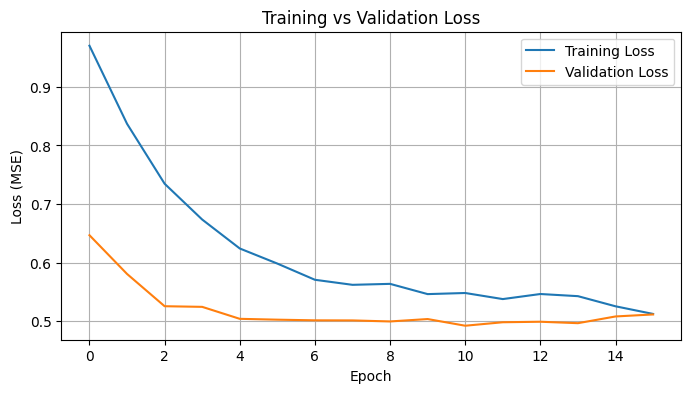

In [190]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# HIDE

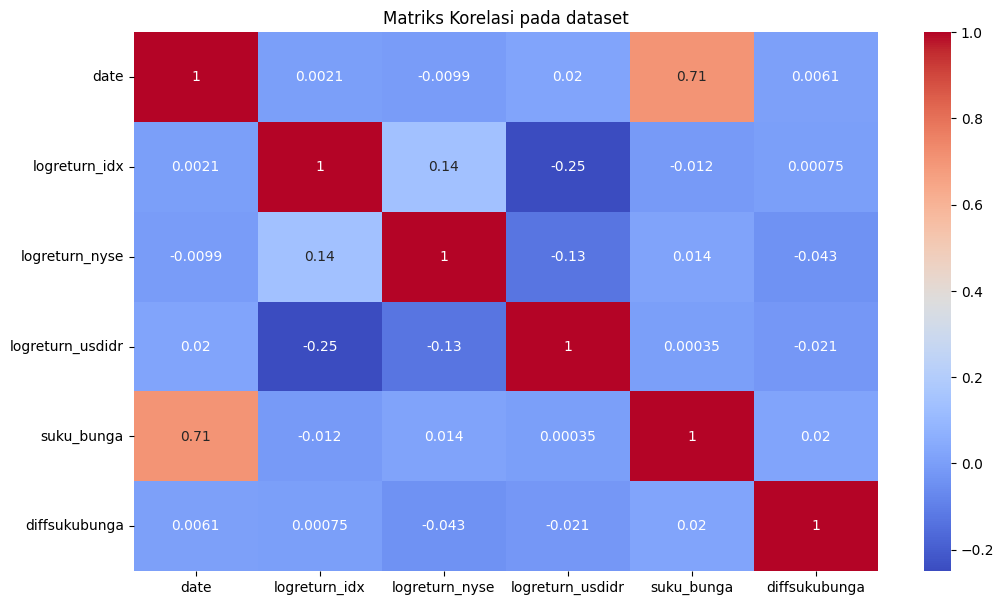

In [8]:
corelation_matrix = df.corr(method='spearman') #hitung korelasi tiap variabel

plt.figure(figsize=(12,7)) #ukuran matriks visualisasi
sns.heatmap(
    corelation_matrix, #ambil nilai korelasi
    annot=True, #tampilkan nilai angka korelasi
    cmap='coolwarm' #tema warna
) 
plt.title('Matriks Korelasi pada dataset')
plt.show()

In [ ]:
corr_matrix = df.corr(method='spearman')
print(corr_matrix)

plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix,
    annot=True,        # tampilkan nilai korelasi
    cmap='coolwarm',   # warna
    fmt=".2f",
    linewidths=0.5
)
plt.title('Heatmap Korelasi Variabel')
plt.show()


In [ ]:
mlflow.tensorflow.autolog()

In [13]:
vol = df[['cond_vol_garch_11']].dropna()

scaler = MinMaxScaler()
vol_scaled = scaler.fit_transform(vol)

In [14]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

WINDOW = 20

X, y = create_sequences(vol_scaled, WINDOW)

# reshape untuk LSTM: (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)


In [15]:
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [16]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    return mae, rmse, mape, r2

In [17]:
def build_lstm_model(input_shape, n_layers, n_units, dropout_rate, learning_rate):
    
    model = Sequential()

    for i in range(n_layers):
        return_seq = i < n_layers - 1
        model.add(
            LSTM(
                n_units,
                return_sequences=return_seq,
                input_shape=input_shape if i == 0 else None
            )
        )
        model.add(Dropout(dropout_rate))

    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='mse'
    )

    return model


In [18]:
param_grid = {
    'n_layers': [1, 2, 3],
    'n_units': [32, 64, 128],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.0001, 0.01],
    'batch_size': [16, 32, 64],
    'epochs': [50]  # tetap agar adil
}


In [ ]:
experiment_name = "LSTM_GARCH_Volatility_Tuning"
mlflow.set_experiment(experiment_name)

run_counter = 1

for n_layers in param_grid['n_layers']:
    for n_units in param_grid['n_units']:
        for dropout_rate in param_grid['dropout_rate']:
            for lr in param_grid['learning_rate']:
                for batch_size in param_grid['batch_size']:

                    with mlflow.start_run(run_name=f"run_{run_counter}"):

                        model = build_lstm_model(
                            input_shape=(X_train.shape[1], 1),
                            n_layers=n_layers,
                            n_units=n_units,
                            dropout_rate=dropout_rate,
                            learning_rate=lr
                        )

                        history = model.fit(
                            X_train, y_train,
                            validation_data=(X_test, y_test),
                            epochs=param_grid['epochs'][0],
                            batch_size=batch_size,
                            verbose=0
                        )

                        # Prediction
                        y_pred = model.predict(X_test)

                        # Inverse scaling
                        y_test_inv = scaler.inverse_transform(
                            y_test.reshape(-1,1)
                        )
                        y_pred_inv = scaler.inverse_transform(y_pred)

                        # Evaluation
                        mae, rmse, mape, r2 = evaluate_model(
                            y_test_inv, y_pred_inv
                        )

                        # Log parameters
                        mlflow.log_param("n_layers", n_layers)
                        mlflow.log_param("n_units", n_units)
                        mlflow.log_param("dropout_rate", dropout_rate)
                        mlflow.log_param("learning_rate", lr)
                        mlflow.log_param("batch_size", batch_size)

                        # Log metrics
                        mlflow.log_metric("MAE", mae)
                        mlflow.log_metric("RMSE", rmse)
                        mlflow.log_metric("MAPE", mape)
                        mlflow.log_metric("R2", r2)

                        run_counter += 1


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
mlflow.ui